In [ ]:
!pip install rarfile

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from sklearn.metrics import accuracy_score
import os
import rarfile
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
import rarfile

# آدرس فایل RAR
rar_file_path = "/content/drive/My Drive/good_images.rar"

# باز کردن فایل RAR
with rarfile.RarFile(rar_file_path) as rf:
    rf.extractall("/content/images_files/")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets, models
from sklearn.model_selection import train_test_split
import os
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score


#func


In [ ]:

# تعریف تنظیمات و پارامترها
IMAGE_SIZE = 128
BATCH_SIZE = 24
EPOCHS = 10
LEARNING_RATE = 0.00001

In [ ]:

# 1. آماده‌سازی داده‌ها
class CustomDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.categories = os.listdir(image_dir)

        # خواندن تصاویر و برچسب‌ها
        for label, category in enumerate(self.categories):
            category_path = os.path.join(image_dir, category)
            for image_name in os.listdir(category_path):
                if image_name.endswith(".jpg") or image_name.endswith(".png"):
                    self.images.append(os.path.join(category_path, image_name))
                    self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label

# تعریف transform‌ها برای داده‌ها
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# بارگذاری داده‌ها
image_dir = "/content/images_files/good_images"
dataset = CustomDataset(image_dir, transform)

In [ ]:
from sklearn.model_selection import train_test_split

# تقسیم داده‌ها: ابتدا Train و Temporary (Validation + Test)
train_data, temp_data = train_test_split(dataset, test_size=0.3, stratify=dataset.labels)

# تقسیم Temporary به Validation و Test
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=[d[1] for d in temp_data])

# ایجاد DataLoader‌ها
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
# تابع آموزش مدل
def train_model_with_validation(model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        # آموزش روی داده‌های Train
        for images, labels in train_loader:
            images, labels = images.to("cuda"), labels.to("cuda")
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # ارزیابی روی داده‌های Validation
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to("cuda"), labels.to("cuda")
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy * 100)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%")

    return train_losses, val_losses, val_accuracies


##mobilenet_v2


In [ ]:
# تعریف مدل
mobilenet_model = models.mobilenet_v2(weights='IMAGENET1K_V1')  # وزن‌های از پیش آموزش دیده
num_features = mobilenet_model.last_channel  # تعداد ویژگی‌های خروجی
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها (بر اساس داده‌های شما)

# فریز کردن تمام وزن‌های مدل به جز کلاسیفایر
for param in mobilenet_model.parameters():
    param.requires_grad = False

# تغییر لایه کلاسیفایر
mobilenet_model.classifier[1] = nn.Linear(num_features, num_classes)

# فقط لایه کلاسیفایر قابل آموزش است
for param in mobilenet_model.classifier.parameters():
    param.requires_grad = True

mobilenet_model = mobilenet_model.to("cuda")

# تعریف Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_model.classifier.parameters(), lr=0.00005)  # فقط وزن‌های کلاسیفایر آپدیت می‌شوند

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    mobilenet_model, train_loader, val_loader, criterion, optimizer,30
)

Epoch 1/30, Train Loss: 1.9421, Val Loss: 1.5547, Val Accuracy: 65.72%
Epoch 2/30, Train Loss: 1.3493, Val Loss: 1.1446, Val Accuracy: 75.02%
Epoch 3/30, Train Loss: 1.0726, Val Loss: 0.9662, Val Accuracy: 77.53%
Epoch 4/30, Train Loss: 0.9211, Val Loss: 0.8159, Val Accuracy: 79.15%
Epoch 5/30, Train Loss: 0.8266, Val Loss: 0.7764, Val Accuracy: 79.92%
Epoch 6/30, Train Loss: 0.7611, Val Loss: 0.7096, Val Accuracy: 80.12%
Epoch 7/30, Train Loss: 0.7177, Val Loss: 0.6678, Val Accuracy: 80.57%
Epoch 8/30, Train Loss: 0.6790, Val Loss: 0.6454, Val Accuracy: 80.70%
Epoch 9/30, Train Loss: 0.6484, Val Loss: 0.6164, Val Accuracy: 81.54%
Epoch 10/30, Train Loss: 0.6303, Val Loss: 0.6072, Val Accuracy: 81.34%
Epoch 11/30, Train Loss: 0.6226, Val Loss: 0.5811, Val Accuracy: 81.67%
Epoch 12/30, Train Loss: 0.5991, Val Loss: 0.5761, Val Accuracy: 82.38%
Epoch 13/30, Train Loss: 0.5820, Val Loss: 0.5674, Val Accuracy: 81.60%
Epoch 14/30, Train Loss: 0.5710, Val Loss: 0.5632, Val Accuracy: 82.12%
E

In [ ]:
# ارزیابی روی داده‌های Test
def evaluate_model_on_test(model, test_loader):
    model.eval()
    test_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
    return test_loss / len(test_loader), test_accuracy * 100

test_loss, test_accuracy = evaluate_model_on_test(mobilenet_model, test_loader)


Test Loss: 0.4703, Test Accuracy: 85.16%


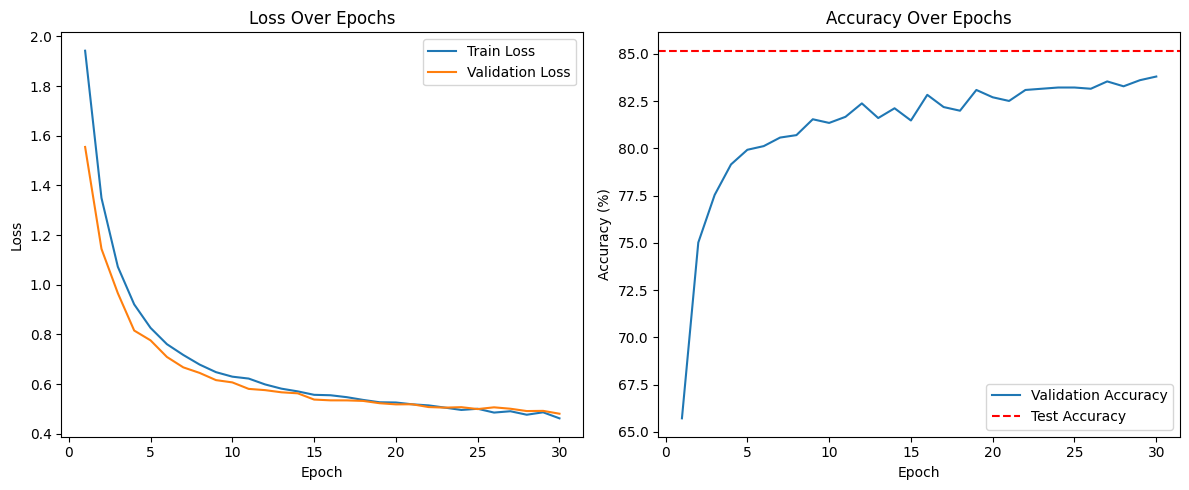

In [ ]:
# رسم نمودار دقت و Loss
def plot_metrics(train_losses, val_losses, val_accuracies, test_accuracy):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # نمودار Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    # نمودار Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.axhline(y=test_accuracy, color='r', linestyle='--', label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, val_losses, val_accuracies, test_accuracy)


In [ ]:
#good
from sklearn.metrics import classification_report

# ارزیابی مدل EfficientNet-B0 با نمایش دقت هر دسته
def evaluate_efficientnet_model_per_category(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to("cuda" if torch.cuda.is_available() else "cpu"), labels.to("cuda" if torch.cuda.is_available() else "cpu")
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # نمایش دقت کلی
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Overall Accuracy: {accuracy * 100:.2f}%")

    # نمایش دقت هر دسته با استفاده از classification_report
    category_names = dataset.categories  # نام دسته‌ها از داده‌ها
    report = classification_report(all_labels, all_preds, target_names=category_names)
    print("\nCategory-wise Accuracy:\n", report)

# فراخوانی تابع ارزیابی
evaluate_efficientnet_model_per_category(mobilenet_model, test_loader)

Overall Accuracy: 85.16%

Category-wise Accuracy:
               precision    recall  f1-score   support

         403       0.80      0.79      0.79       161
         248       0.98      0.95      0.96       165
         300       0.93      0.99      0.96       166
         372       0.68      0.55      0.61       133
         357       0.94      0.96      0.95       155
         242       0.91      0.92      0.91       177
         321       0.72      0.74      0.73       154
         311       0.88      0.97      0.92       127
         358       0.89      0.92      0.91       154
         365       0.71      0.68      0.70       158

    accuracy                           0.85      1550
   macro avg       0.84      0.85      0.84      1550
weighted avg       0.85      0.85      0.85      1550



In [ ]:
# تعریف مدل
mobilenet_model = models.mobilenet_v2(weights='IMAGENET1K_V1')  # استفاده از وزن‌های از پیش آموزش دیده
num_features = mobilenet_model.last_channel  # تعداد ویژگی‌های خروجی آخرین لایه
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها (بر اساس داده‌های شما)
mobilenet_model.classifier[1] = nn.Linear(num_features, num_classes)  # تغییر لایه خروجی برای تعداد کلاس‌ها
mobilenet_model = mobilenet_model.to("cuda")

# تعریف Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_model.parameters(), lr=0.00003)

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    mobilenet_model, train_loader, val_loader, criterion, optimizer
)

Epoch 1/10, Train Loss: 1.0443, Val Loss: 0.4886, Val Accuracy: 84.51%
Epoch 2/10, Train Loss: 0.4452, Val Loss: 0.3756, Val Accuracy: 87.60%
Epoch 3/10, Train Loss: 0.3011, Val Loss: 0.3409, Val Accuracy: 88.70%
Epoch 4/10, Train Loss: 0.2211, Val Loss: 0.3280, Val Accuracy: 90.32%
Epoch 5/10, Train Loss: 0.1576, Val Loss: 0.3271, Val Accuracy: 89.74%
Epoch 6/10, Train Loss: 0.1187, Val Loss: 0.3176, Val Accuracy: 90.19%
Epoch 7/10, Train Loss: 0.0827, Val Loss: 0.3446, Val Accuracy: 89.99%
Epoch 8/10, Train Loss: 0.0632, Val Loss: 0.3468, Val Accuracy: 89.99%
Epoch 9/10, Train Loss: 0.0467, Val Loss: 0.3594, Val Accuracy: 89.99%
Epoch 10/10, Train Loss: 0.0372, Val Loss: 0.3668, Val Accuracy: 89.86%


##ResNet-50

In [ ]:
# تعریف مدل
resnet_model = models.resnet50(weights='IMAGENET1K_V1')  # وزن‌های از پیش آموزش‌دیده
num_features = resnet_model.fc.in_features  # تعداد ویژگی‌های ورودی به لایه کلاسیفایر
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها بر اساس داده‌های شما

# تغییر لایه کلاسیفایر برای تعداد کلاس‌های جدید
resnet_model.fc = nn.Linear(num_features, num_classes)
resnet_model = resnet_model.to("cuda")

# تعریف Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.00005)  # تمام وزن‌های مدل بهینه‌سازی می‌شوند

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    resnet_model, train_loader, val_loader, criterion, optimizer
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 169MB/s]


Epoch 1/10, Train Loss: 0.6198, Val Loss: 0.3339, Val Accuracy: 88.96%
Epoch 2/10, Train Loss: 0.1871, Val Loss: 0.3400, Val Accuracy: 88.64%
Epoch 3/10, Train Loss: 0.0860, Val Loss: 0.3156, Val Accuracy: 89.80%
Epoch 4/10, Train Loss: 0.0503, Val Loss: 0.3881, Val Accuracy: 88.83%
Epoch 5/10, Train Loss: 0.0455, Val Loss: 0.3993, Val Accuracy: 89.28%
Epoch 6/10, Train Loss: 0.0613, Val Loss: 0.3103, Val Accuracy: 90.64%
Epoch 7/10, Train Loss: 0.0318, Val Loss: 0.3737, Val Accuracy: 89.48%
Epoch 8/10, Train Loss: 0.0262, Val Loss: 0.4000, Val Accuracy: 89.28%
Epoch 9/10, Train Loss: 0.0374, Val Loss: 0.3862, Val Accuracy: 88.90%
Epoch 10/10, Train Loss: 0.0420, Val Loss: 0.3958, Val Accuracy: 89.41%


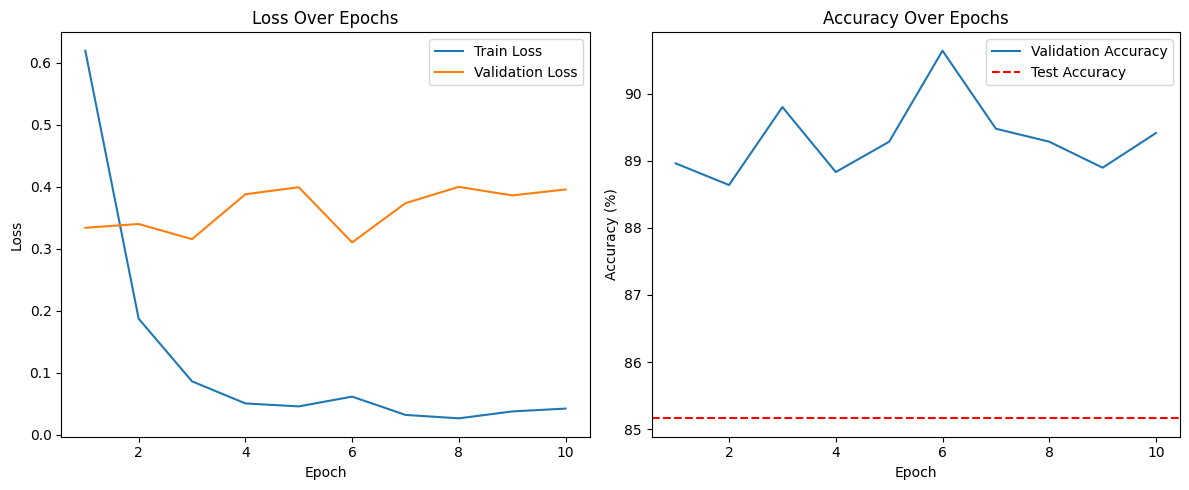

In [ ]:
# رسم نمودار دقت و Loss
def plot_metrics(train_losses, val_losses, val_accuracies, test_accuracy):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # نمودار Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    # نمودار Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.axhline(y=test_accuracy, color='r', linestyle='--', label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, val_losses, val_accuracies, test_accuracy)


In [ ]:
#good
from sklearn.metrics import classification_report

def evaluate_efficientnet_model_per_category(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to("cuda" if torch.cuda.is_available() else "cpu"), labels.to("cuda" if torch.cuda.is_available() else "cpu")
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # نمایش دقت کلی
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Overall Accuracy: {accuracy * 100:.2f}%")

    # نمایش دقت هر دسته با استفاده از classification_report
    category_names = dataset.categories  # نام دسته‌ها از داده‌ها
    report = classification_report(all_labels, all_preds, target_names=category_names)
    print("\nCategory-wise Accuracy:\n", report)

# فراخوانی تابع ارزیابی
evaluate_efficientnet_model_per_category(resnet_model, test_loader)

Overall Accuracy: 90.26%

Category-wise Accuracy:
               precision    recall  f1-score   support

         403       0.86      0.91      0.89       161
         248       0.94      0.99      0.97       165
         300       0.98      0.99      0.99       166
         372       0.75      0.74      0.75       133
         357       0.99      0.93      0.96       155
         242       0.96      0.94      0.95       177
         321       0.90      0.71      0.79       154
         311       0.96      0.96      0.96       127
         358       0.96      0.97      0.96       154
         365       0.73      0.84      0.78       158

    accuracy                           0.90      1550
   macro avg       0.90      0.90      0.90      1550
weighted avg       0.91      0.90      0.90      1550



In [ ]:

# تعریف مدل
resnet_model = models.resnet50(weights='IMAGENET1K_V1')  # وزن‌های از پیش آموزش‌دیده
num_features = resnet_model.fc.in_features  # تعداد ویژگی‌های ورودی به لایه کلاسیفایر
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها بر اساس داده‌های شما

# فریز کردن تمام لایه‌های مدل به جز کلاسیفایر
for param in resnet_model.parameters():
    param.requires_grad = False

# تغییر لایه کلاسیفایر
resnet_model.fc = nn.Linear(num_features, num_classes)

# فقط لایه کلاسیفایر قابل آموزش است
for param in resnet_model.fc.parameters():
    param.requires_grad = True

resnet_model = resnet_model.to("cuda")

# تعریف Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.fc.parameters(), lr=0.00005)  # فقط لایه کلاسیفایر بهینه‌سازی می‌شود

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    resnet_model, train_loader, val_loader, criterion, optimizer,40
)


Epoch 1/40, Train Loss: 1.7735, Val Loss: 1.3406, Val Accuracy: 74.37%
Epoch 2/40, Train Loss: 1.1506, Val Loss: 0.9690, Val Accuracy: 78.83%
Epoch 3/40, Train Loss: 0.9126, Val Loss: 0.8173, Val Accuracy: 80.70%
Epoch 4/40, Train Loss: 0.7849, Val Loss: 0.7120, Val Accuracy: 79.99%
Epoch 5/40, Train Loss: 0.7139, Val Loss: 0.6635, Val Accuracy: 81.47%
Epoch 6/40, Train Loss: 0.6590, Val Loss: 0.6211, Val Accuracy: 82.05%
Epoch 7/40, Train Loss: 0.6210, Val Loss: 0.5825, Val Accuracy: 82.44%
Epoch 8/40, Train Loss: 0.6007, Val Loss: 0.5671, Val Accuracy: 82.38%
Epoch 9/40, Train Loss: 0.5701, Val Loss: 0.5479, Val Accuracy: 82.83%
Epoch 10/40, Train Loss: 0.5565, Val Loss: 0.5304, Val Accuracy: 83.02%
Epoch 11/40, Train Loss: 0.5404, Val Loss: 0.5247, Val Accuracy: 82.96%
Epoch 12/40, Train Loss: 0.5190, Val Loss: 0.5077, Val Accuracy: 82.83%
Epoch 13/40, Train Loss: 0.5089, Val Loss: 0.4998, Val Accuracy: 83.67%
Epoch 14/40, Train Loss: 0.5072, Val Loss: 0.5027, Val Accuracy: 83.02%
E

In [ ]:
test_loss, test_accuracy = evaluate_model_on_test(resnet_model, test_loader)


Test Loss: 0.4518, Test Accuracy: 84.19%


#امتحان سایر مدل ها

In [ ]:
import timm
import torch.nn as nn
import torch.optim as optim

# تعریف مدل
seresnext_model = timm.create_model('seresnext101_32x4d', pretrained=True)  # مدل SE-ResNeXt-101 با وزن‌های از پیش آموزش‌دیده
num_features = seresnext_model.fc.in_features  # تعداد ویژگی‌های ورودی به لایه کلاسیفایر
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها بر اساس داده‌های شما

# # فریز کردن تمام وزن‌های مدل به جز کلاسیفایر
# for param in seresnext_model.parameters():
#     param.requires_grad = False

# تغییر لایه کلاسیفایر
seresnext_model.fc = nn.Linear(num_features, num_classes)

# # فقط لایه کلاسیفایر قابل آموزش است
# for param in seresnext_model.fc.parameters():
#     param.requires_grad = True

seresnext_model = seresnext_model.to("cuda")

# تعریف Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(seresnext_model.fc.parameters(), lr=0.00005)  # فقط لایه کلاسیفایر بهینه‌سازی می‌شود

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    seresnext_model, train_loader, val_loader, criterion, optimizer
)


Epoch 1/10, Train Loss: 1.9798, Val Loss: 1.7296, Val Accuracy: 55.00%
Epoch 2/10, Train Loss: 1.4424, Val Loss: 1.3721, Val Accuracy: 67.20%
Epoch 3/10, Train Loss: 1.1621, Val Loss: 1.1689, Val Accuracy: 72.30%


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from torch.utils.data import DataLoader
from tqdm import tqdm

# فرض می‌کنیم که train_loader و test_loader از قبل تعریف شده‌اند

# تعریف مدل‌ها
models_dict = {
    'mobilenet_v2': 'mobilenetv2_100',
    'efficientnet_b0': 'efficientnet_b0',
    'resnet18': 'resnet18',
    'resnet50': 'resnet50',
    'densenet121': 'densenet121',
    'efficientnet_b3': 'efficientnet_b3',
    'inception_v3': 'inception_v3',
    'xception': 'xception',
    'efficientnet_b7': 'efficientnet_b7',
    'vit_b16': 'vit_base_patch16_224',
    'swin_base': 'swin_base_patch4_window7_224',
    'convnext_base': 'convnext_base',
    'beit_base': 'beit_base_patch16_224',
}

# تابع برای ارزیابی مدل
def evaluate_model_on_test(model, test_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total
    return test_loss, test_accuracy

# تابع آموزش مدل
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# انتخاب بهترین مدل
best_model = None
best_accuracy = 0
best_model_name = ""
for model_name, model_arch in models_dict.items():
    print(f"\nTraining {model_name}...")
    # بارگذاری مدل
    model = timm.create_model(model_arch, pretrained=True)

    # تغییر لایه کلاسیفایر مدل برای تعداد کلاس‌های داده‌های شما
    if hasattr(model, 'classifier'):
        num_features = model.classifier.in_features
        model.classifier = nn.Linear(num_features, len(set(dataset.labels)))
    elif hasattr(model, 'fc'):
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, len(set(dataset.labels)))
    else:
        # برای مدل‌هایی که ویژگی‌های کلاس خاص دارند، این بخش را اضافه کنید
        num_features = model.head.fc.in_features if hasattr(model, 'head') else model.head.in_features
        model.head.fc = nn.Linear(num_features, len(set(dataset.labels))) if hasattr(model.head, 'fc') else nn.Linear(num_features, len(set(dataset.labels)))

    # انتقال مدل به GPU
    model = model.to("cuda")

    # تعریف Criterion و Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # آموزش مدل
    train_model(model, train_loader, criterion, optimizer, num_epochs=5)

    # ارزیابی مدل روی داده‌های تست
    test_loss, test_accuracy = evaluate_model_on_test(model, test_loader)

    print(f"Test Accuracy for {model_name}: {test_accuracy:.2f}%")

    # ذخیره مدل با بهترین دقت
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model = model
        best_model_name = model_name

# نمایش بهترین مدل
print(f"\nBest Model: {best_model_name} with Test Accuracy: {best_accuracy:.2f}%")




Training mobilenet_v2...


Epoch 1/5: 100%|██████████| 302/302 [00:10<00:00, 28.68it/s]


Epoch [1/5], Loss: 1.1195


Epoch 2/5: 100%|██████████| 302/302 [00:10<00:00, 28.71it/s]


Epoch [2/5], Loss: 0.4837


Epoch 3/5: 100%|██████████| 302/302 [00:10<00:00, 27.95it/s]


Epoch [3/5], Loss: 0.3264


Epoch 4/5: 100%|██████████| 302/302 [00:10<00:00, 28.05it/s]


Epoch [4/5], Loss: 0.2200


Epoch 5/5: 100%|██████████| 302/302 [00:10<00:00, 28.28it/s]


Epoch [5/5], Loss: 0.1584
Test Accuracy for mobilenet_v2: 89.10%

Training efficientnet_b0...


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Epoch 1/5: 100%|██████████| 302/302 [00:14<00:00, 20.27it/s]


Epoch [1/5], Loss: 0.9641


Epoch 2/5: 100%|██████████| 302/302 [00:14<00:00, 20.44it/s]


Epoch [2/5], Loss: 0.3653


Epoch 3/5: 100%|██████████| 302/302 [00:14<00:00, 20.41it/s]


Epoch [3/5], Loss: 0.2109


Epoch 4/5: 100%|██████████| 302/302 [00:14<00:00, 20.49it/s]


Epoch [4/5], Loss: 0.1240


Epoch 5/5: 100%|██████████| 302/302 [00:14<00:00, 20.38it/s]


Epoch [5/5], Loss: 0.0792
Test Accuracy for efficientnet_b0: 90.32%

Training resnet18...


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Epoch 1/5: 100%|██████████| 302/302 [00:10<00:00, 30.17it/s]


Epoch [1/5], Loss: 1.6167


Epoch 2/5: 100%|██████████| 302/302 [00:10<00:00, 30.09it/s]


Epoch [2/5], Loss: 0.7402


Epoch 3/5: 100%|██████████| 302/302 [00:10<00:00, 29.97it/s]


Epoch [3/5], Loss: 0.4963


Epoch 4/5: 100%|██████████| 302/302 [00:10<00:00, 30.08it/s]


Epoch [4/5], Loss: 0.3720


Epoch 5/5: 100%|██████████| 302/302 [00:10<00:00, 30.08it/s]


Epoch [5/5], Loss: 0.2909
Test Accuracy for resnet18: 88.00%

Training resnet50...


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Epoch 1/5: 100%|██████████| 302/302 [00:26<00:00, 11.22it/s]


Epoch [1/5], Loss: 1.4604


Epoch 2/5: 100%|██████████| 302/302 [00:26<00:00, 11.20it/s]


Epoch [2/5], Loss: 0.4994


Epoch 3/5: 100%|██████████| 302/302 [00:26<00:00, 11.21it/s]


Epoch [3/5], Loss: 0.3253


Epoch 4/5: 100%|██████████| 302/302 [00:26<00:00, 11.23it/s]


Epoch [4/5], Loss: 0.2261


Epoch 5/5: 100%|██████████| 302/302 [00:26<00:00, 11.24it/s]


Epoch [5/5], Loss: 0.1588
Test Accuracy for resnet50: 90.71%

Training densenet121...


model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

Epoch 1/5: 100%|██████████| 302/302 [00:27<00:00, 10.80it/s]


Epoch [1/5], Loss: 0.9542


Epoch 2/5: 100%|██████████| 302/302 [00:28<00:00, 10.78it/s]


Epoch [2/5], Loss: 0.3512


Epoch 3/5: 100%|██████████| 302/302 [00:27<00:00, 10.81it/s]


Epoch [3/5], Loss: 0.1897


Epoch 4/5: 100%|██████████| 302/302 [00:27<00:00, 10.84it/s]


Epoch [4/5], Loss: 0.1045


Epoch 5/5: 100%|██████████| 302/302 [00:28<00:00, 10.71it/s]


Epoch [5/5], Loss: 0.0741
Test Accuracy for densenet121: 89.81%

Training efficientnet_b3...


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

Epoch 1/5: 100%|██████████| 302/302 [00:28<00:00, 10.75it/s]


Epoch [1/5], Loss: 0.9841


Epoch 2/5: 100%|██████████| 302/302 [00:28<00:00, 10.73it/s]


Epoch [2/5], Loss: 0.3279


Epoch 3/5: 100%|██████████| 302/302 [00:27<00:00, 10.81it/s]


Epoch [3/5], Loss: 0.1605


Epoch 4/5: 100%|██████████| 302/302 [00:27<00:00, 10.82it/s]


Epoch [4/5], Loss: 0.0894


Epoch 5/5: 100%|██████████| 302/302 [00:27<00:00, 10.84it/s]


Epoch [5/5], Loss: 0.0521
Test Accuracy for efficientnet_b3: 88.97%

Training inception_v3...


model.safetensors:   0%|          | 0.00/95.5M [00:00<?, ?B/s]

Epoch 1/5: 100%|██████████| 302/302 [00:23<00:00, 12.89it/s]


Epoch [1/5], Loss: 0.9464


Epoch 2/5: 100%|██████████| 302/302 [00:23<00:00, 12.98it/s]


Epoch [2/5], Loss: 0.4026


Epoch 3/5: 100%|██████████| 302/302 [00:23<00:00, 12.97it/s]


Epoch [3/5], Loss: 0.2320


Epoch 4/5: 100%|██████████| 302/302 [00:23<00:00, 13.10it/s]


Epoch [4/5], Loss: 0.1608


Epoch 5/5: 100%|██████████| 302/302 [00:23<00:00, 12.64it/s]


Epoch [5/5], Loss: 0.1065
Test Accuracy for inception_v3: 86.97%

Training xception...


/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth
Epoch 1/5: 100%|██████████| 302/302 [00:38<00:00,  7.92it/s]


Epoch [1/5], Loss: 0.8633


Epoch 2/5: 100%|██████████| 302/302 [00:37<00:00,  7.95it/s]


Epoch [2/5], Loss: 0.2347


Epoch 3/5: 100%|██████████| 302/302 [00:37<00:00,  7.96it/s]


Epoch [3/5], Loss: 0.0881


Epoch 4/5: 100%|██████████| 302/302 [00:37<00:00,  7.95it/s]


Epoch [4/5], Loss: 0.0482


Epoch 5/5: 100%|██████████| 302/302 [00:38<00:00,  7.94it/s]


Epoch [5/5], Loss: 0.0290
Test Accuracy for xception: 89.23%

Training efficientnet_b7...


RuntimeError: No pretrained weights exist for efficientnet_b7. Use `pretrained=False` for random init.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import timm

# تنظیمات پایه
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
learning_rate = 0.001
num_epochs = 5

# دیتاست و لود کننده‌ها
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = datasets.FakeData(transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# تابع آموزش
def train_model(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels.data)

    return total_loss / len(train_loader), correct.double() / len(train_loader.dataset)

# تابع ارزیابی
def evaluate_model(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)

    return total_loss / len(val_loader), correct.double() / len(val_loader.dataset)

# مدل‌ها و معماری‌ها
models_to_train = [
    "efficientnet_b7",
    "vit_base_patch16_224",
    "swin_base_patch4_window7_224",
    "convnext_base",
    "beit_base_patch16_224",
]

# حلقه آموزش برای هر مدل
results = {}
for model_name in models_to_train:
    print(f"\nTraining {model_name}...")
    try:
        # بارگذاری مدل
        model = timm.create_model(model_name, pretrained=True)
        model = model.to(device)

        # تغییر لایه کلاسیفایر مدل برای تعداد کلاس‌ها
        try:
            if hasattr(model, 'classifier'):
                num_features = model.classifier.in_features
                model.classifier = nn.Linear(num_features, len(set(dataset.labels)))
            elif hasattr(model, 'fc'):
                num_features = model.fc.in_features
                model.fc = nn.Linear(num_features, len(set(dataset.labels)))
            elif hasattr(model, 'head'):
                if hasattr(model.head, 'fc'):
                    num_features = model.head.fc.in_features
                    model.head.fc = nn.Linear(num_features, len(set(dataset.labels)))
                else:
                    num_features = model.head.in_features
                    model.head = nn.Linear(num_features, len(set(dataset.labels)))
            elif hasattr(model, 'pre_logits'):
                # برای مدل‌هایی مانند ViT
                num_features = model.pre_logits.in_features
                model.head = nn.Linear(num_features, len(set(dataset.labels)))
            else:
                raise AttributeError("Unsupported model architecture: Cannot find a classifier or head layer.")
        except AttributeError as e:
            print(f"Error adjusting classifier for model {model_name}: {e}")
            continue

        # تعریف معیار و بهینه‌ساز
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # حلقه آموزش
        for epoch in range(num_epochs):
            train_loss, train_accuracy = train_model(model, train_loader, criterion, optimizer)
            val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
            print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

        # ارزیابی نهایی
        test_loss, test_accuracy = evaluate_model(model, val_loader, criterion)
        results[model_name] = (test_loss, test_accuracy)

    except Exception as e:
        print(f"Error training {model_name}: {e}")

# نمایش نتایج
print("\nFinal Results:")
for model_name, (test_loss, test_accuracy) in results.items():
    print(f"{model_name}: Test Loss = {test_loss:.4f}, Test Accuracy = {test_accuracy:.4f}")




Training efficientnet_b7...
Error training efficientnet_b7: No pretrained weights exist for efficientnet_b7. Use `pretrained=False` for random init.

Training vit_base_patch16_224...
Error adjusting classifier for model vit_base_patch16_224: 'FakeData' object has no attribute 'labels'

Training swin_base_patch4_window7_224...


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Error adjusting classifier for model swin_base_patch4_window7_224: 'FakeData' object has no attribute 'labels'

Training convnext_base...


model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

Error adjusting classifier for model convnext_base: 'FakeData' object has no attribute 'labels'

Training beit_base_patch16_224...


model.safetensors:   0%|          | 0.00/350M [00:00<?, ?B/s]

Error adjusting classifier for model beit_base_patch16_224: 'FakeData' object has no attribute 'labels'

Final Results:


In [ ]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim

# تعریف مدل
vit_model = timm.create_model("vit_base_patch16_224", pretrained=True)  # مدل با وزن‌های از پیش آموزش‌دیده
num_features = vit_model.head.in_features  # تعداد ویژگی‌های خروجی از لایه قبلی به کلاسیفایر
num_classes = 10  # تعداد کلاس‌ها را مطابق مجموعه داده تنظیم کنید

# تغییر لایه کلاسیفایر برای تعداد کلاس‌های جدید
vit_model.head = nn.Linear(num_features, num_classes)
vit_model = vit_model.to("cuda")

# تعریف Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_model.parameters(), lr=0.00005)  # تمام وزن‌های مدل بهینه‌سازی می‌شوند

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    vit_model, train_loader, val_loader, criterion, optimizer
)


Epoch 1/10, Train Loss: 2.4008, Val Loss: 2.4370, Val Accuracy: 6.50%
Epoch 2/10, Train Loss: 2.3487, Val Loss: 2.3531, Val Accuracy: 14.50%
Epoch 3/10, Train Loss: 2.3423, Val Loss: 2.3017, Val Accuracy: 10.00%
Epoch 4/10, Train Loss: 2.3381, Val Loss: 2.3261, Val Accuracy: 8.00%
Epoch 5/10, Train Loss: 2.3166, Val Loss: 2.3289, Val Accuracy: 10.00%
Epoch 6/10, Train Loss: 2.3101, Val Loss: 2.3099, Val Accuracy: 8.50%
Epoch 7/10, Train Loss: 2.3087, Val Loss: 2.3232, Val Accuracy: 13.50%
Epoch 8/10, Train Loss: 2.2924, Val Loss: 2.3084, Val Accuracy: 14.00%
Epoch 9/10, Train Loss: 2.1844, Val Loss: 2.4212, Val Accuracy: 7.50%
Epoch 10/10, Train Loss: 2.0836, Val Loss: 2.5975, Val Accuracy: 13.50%


In [ ]:
# تعریف مدل
mobilenet_model = models.mobilenet_v2(weights='IMAGENET1K_V1')  # استفاده از وزن‌های از پیش آموزش دیده
num_features = mobilenet_model.last_channel  # تعداد ویژگی‌های خروجی آخرین لایه
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها (بر اساس داده‌های شما)
mobilenet_model.classifier[1] = nn.Linear(num_features, num_classes)  # تغییر لایه خروجی برای تعداد کلاس‌ها
mobilenet_model = mobilenet_model.to("cuda")

# تعریف Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_model.parameters(), lr=0.00003)

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    mobilenet_model, train_loader, val_loader, criterion, optimizer
)

Epoch 1/10, Train Loss: 1.0443, Val Loss: 0.4886, Val Accuracy: 84.51%
Epoch 2/10, Train Loss: 0.4452, Val Loss: 0.3756, Val Accuracy: 87.60%
Epoch 3/10, Train Loss: 0.3011, Val Loss: 0.3409, Val Accuracy: 88.70%
Epoch 4/10, Train Loss: 0.2211, Val Loss: 0.3280, Val Accuracy: 90.32%
Epoch 5/10, Train Loss: 0.1576, Val Loss: 0.3271, Val Accuracy: 89.74%
Epoch 6/10, Train Loss: 0.1187, Val Loss: 0.3176, Val Accuracy: 90.19%
Epoch 7/10, Train Loss: 0.0827, Val Loss: 0.3446, Val Accuracy: 89.99%
Epoch 8/10, Train Loss: 0.0632, Val Loss: 0.3468, Val Accuracy: 89.99%
Epoch 9/10, Train Loss: 0.0467, Val Loss: 0.3594, Val Accuracy: 89.99%
Epoch 10/10, Train Loss: 0.0372, Val Loss: 0.3668, Val Accuracy: 89.86%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# مسیر فایل وزن‌ها (در فرمت PyTorch)
local_weights_path = '/content/efficientnetb0_notop.h5'  # فایل وزن‌ها باید با فرمت PyTorch باشد

# بررسی دستگاه (GPU یا CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# بارگذاری مدل EfficientNetB0
efficientnet_model = models.efficientnet_b0(weights=None)  # بدون وزن‌های پیش‌آماده
try:
    # بارگذاری وزن‌های از پیش آموزش‌دیده
    state_dict = torch.load(local_weights_path, map_location=device)
    efficientnet_model.load_state_dict(state_dict)
    print("وزن‌ها با موفقیت بارگذاری شدند.")
except Exception as e:
    print(f"خطا در بارگذاری وزن‌ها: {e}")
    exit()

# تغییر لایه طبقه‌بندی (Classifier) برای تعداد کلاس‌های موردنظر
num_features = efficientnet_model.classifier[1].in_features
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها (بر اساس داده‌های شما)
efficientnet_model.classifier = nn.Sequential(
    nn.Linear(num_features, 256),  # لایه میانی (اختیاری)
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)

# انتقال مدل به دستگاه
efficientnet_model = efficientnet_model.to(device)

# تعریف Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_model.parameters(), lr=5e-5)

# حلقه آموزش
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # ارزیابی مدل روی مجموعه اعتبارسنجی
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100.0 * correct / total)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")

    return train_losses, val_losses, val_accuracies

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model(
    efficientnet_model, train_loader, val_loader, criterion, optimizer, epochs=40
)


<ipython-input-6-ce14724eca48>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(local_weights_path, map_location=device)


خطا در بارگذاری وزن‌ها: invalid load key, 'H'.
Epoch 1/40, Train Loss: 2.2857, Val Loss: 2.2551, Val Accuracy: 18.21%
Epoch 2/40, Train Loss: 2.1430, Val Loss: 1.9312, Val Accuracy: 31.63%
Epoch 3/40, Train Loss: 1.9281, Val Loss: 1.8211, Val Accuracy: 38.22%
Epoch 4/40, Train Loss: 1.7635, Val Loss: 1.6937, Val Accuracy: 43.64%
Epoch 5/40, Train Loss: 1.6199, Val Loss: 1.5752, Val Accuracy: 46.68%
Epoch 6/40, Train Loss: 1.5043, Val Loss: 1.5116, Val Accuracy: 48.16%
Epoch 7/40, Train Loss: 1.3928, Val Loss: 1.5169, Val Accuracy: 49.06%
Epoch 8/40, Train Loss: 1.2917, Val Loss: 1.4702, Val Accuracy: 50.68%
Epoch 9/40, Train Loss: 1.2168, Val Loss: 1.5529, Val Accuracy: 50.42%
Epoch 10/40, Train Loss: 1.1160, Val Loss: 1.5573, Val Accuracy: 50.74%
Epoch 11/40, Train Loss: 1.0422, Val Loss: 1.5591, Val Accuracy: 50.29%
Epoch 12/40, Train Loss: 0.9741, Val Loss: 1.5740, Val Accuracy: 50.94%
Epoch 13/40, Train Loss: 0.9318, Val Loss: 1.6289, Val Accuracy: 51.26%
Epoch 14/40, Train Loss: 0

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models

# بررسی دستگاه (GPU یا CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# تعریف مدل ResNet18
model_ft = models.resnet50(pretrained=True)  # دانلود وزن‌های پیش‌آماده
num_ftrs = model_ft.fc.in_features  # استخراج تعداد ویژگی‌های لایه fully connected
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها
model_ft.fc = nn.Linear(num_ftrs, num_classes)  # تغییر تعداد نودهای خروجی به تعداد کلاس‌ها

# انتقال مدل به دستگاه
model_ft = model_ft.to(device)

# تعریف Criterion و Optimizer
criterion = nn.CrossEntropyLoss()  # تابع هزینه
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)  # بهینه‌سازی با SGD

# کاهش نرخ یادگیری با یک ضریب مشخص پس از هر 7 دوره
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# حلقه آموزش
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        print('-' * 10)

        # مرحله آموزش
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # مرحله اعتبارسنجی
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100.0 * correct / total)

        print(f"Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
              f"Val Accuracy: {val_accuracies[-1]:.2f}%")

        # به‌روزرسانی scheduler
        scheduler.step()

    return train_losses, val_losses, val_accuracies

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model(
    model_ft, train_loader, val_loader, criterion, optimizer_ft, exp_lr_scheduler, epochs=10
)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
----------
Train Loss: 0.6554, Val Loss: 0.3769, Val Accuracy: 87.15%
Epoch 2/10
----------
Train Loss: 0.2154, Val Loss: 0.3225, Val Accuracy: 89.41%
Epoch 3/10
----------
Train Loss: 0.0975, Val Loss: 0.3024, Val Accuracy: 90.19%
Epoch 4/10
----------
Train Loss: 0.0475, Val Loss: 0.3185, Val Accuracy: 90.51%
Epoch 5/10
----------
Train Loss: 0.0346, Val Loss: 0.3566, Val Accuracy: 90.51%
Epoch 6/10
----------
Train Loss: 0.0188, Val Loss: 0.3455, Val Accuracy: 90.06%
Epoch 7/10
----------
Train Loss: 0.0184, Val Loss: 0.3609, Val Accuracy: 90.96%
Epoch 8/10
----------
Train Loss: 0.0124, Val Loss: 0.3575, Val Accuracy: 90.45%
Epoch 9/10
----------
Train Loss: 0.0110, Val Loss: 0.3533, Val Accuracy: 90.38%
Epoch 10/10
----------
Train Loss: 0.0092, Val Loss: 0.3549, Val Accuracy: 90.96%


In [ ]:
test_loss, test_accuracy = evaluate_model_on_test(model_ft, test_loader)

Test Loss: 0.3407, Test Accuracy: 91.74%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms

# پیش‌پردازش داده‌ها
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # تغییر اندازه به 299x299
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # نرمال‌سازی
])



# تعریف مدل InceptionV3
inception_model = models.inception_v3(weights='IMAGENET1K_V1')
num_features = inception_model.fc.in_features
num_classes = 10  # تعداد کلاس‌ها بر اساس داده‌های آموزشی
inception_model.fc = nn.Linear(num_features, num_classes)  # تغییر لایه خروجی
inception_model.aux_logits = False  # غیرفعال کردن خروجی کمکی
inception_model = inception_model.to("cuda")

# تعریف Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(inception_model.parameters(), lr=0.00003)

# تابع آموزش
def train_model_with_validation(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    model.train()
    train_losses, val_losses, val_accuracies = [], [], []

    for epoch in range(epochs):
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to("cuda"), labels.to("cuda")
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # اعتبارسنجی
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to("cuda"), labels.to("cuda")
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # ثبت نتایج
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct / total)

        print(f"Epoch {epoch + 1}/{epochs}, "
              f"Train Loss: {train_losses[-1]:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, "
              f"Val Accuracy: {val_accuracies[-1]:.4f}")

        model.train()

    return train_losses, val_losses, val_accuracies

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    inception_model, train_loader, val_loader, criterion, optimizer, epochs=10
)


RuntimeError: Calculated padded input size per channel: (1 x 1). Kernel size: (5 x 5). Kernel size can't be greater than actual input size

In [ ]:
#good_24_0.00003
# تعریف مدل
efficientnet_model = models.efficientnet_b0(weights='IMAGENET1K_V1')  # تغییر مدل به B5
num_features = efficientnet_model.classifier[1].in_features
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها (بر اساس داده‌های شما)
efficientnet_model.classifier[1] = nn.Linear(num_features, num_classes)
efficientnet_model = efficientnet_model.to("cuda")

# تعریف Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.00003)

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    efficientnet_model, train_loader, val_loader, criterion, optimizer
)

Epoch 1/20, Train Loss: 1.6284, Val Loss: 0.9466, Val Accuracy: 76.69%
Epoch 2/20, Train Loss: 0.8272, Val Loss: 0.5260, Val Accuracy: 85.86%
Epoch 3/20, Train Loss: 0.5796, Val Loss: 0.4009, Val Accuracy: 87.86%
Epoch 4/20, Train Loss: 0.4704, Val Loss: 0.3396, Val Accuracy: 89.22%
Epoch 5/20, Train Loss: 0.3916, Val Loss: 0.3143, Val Accuracy: 89.67%
Epoch 6/20, Train Loss: 0.3335, Val Loss: 0.2763, Val Accuracy: 90.90%
Epoch 7/20, Train Loss: 0.2815, Val Loss: 0.2641, Val Accuracy: 91.41%
Epoch 8/20, Train Loss: 0.2328, Val Loss: 0.2572, Val Accuracy: 91.09%
Epoch 9/20, Train Loss: 0.2148, Val Loss: 0.2504, Val Accuracy: 91.35%
Epoch 10/20, Train Loss: 0.1843, Val Loss: 0.2529, Val Accuracy: 91.74%
Epoch 11/20, Train Loss: 0.1557, Val Loss: 0.2479, Val Accuracy: 91.67%
Epoch 12/20, Train Loss: 0.1397, Val Loss: 0.2628, Val Accuracy: 90.90%
Epoch 13/20, Train Loss: 0.1191, Val Loss: 0.2660, Val Accuracy: 90.83%
Epoch 14/20, Train Loss: 0.1088, Val Loss: 0.2540, Val Accuracy: 91.54%
E

KeyboardInterrupt: 

In [ ]:
#good
# تعریف مدل
efficientnet_model = models.efficientnet_b0(weights='IMAGENET1K_V1')  # تغییر مدل به B5
num_features = efficientnet_model.classifier[1].in_features
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها (بر اساس داده‌های شما)
efficientnet_model.classifier[1] = nn.Linear(num_features, num_classes)
efficientnet_model = efficientnet_model.to("cuda")

# تعریف Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.0001)

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    efficientnet_model, train_loader, val_loader, criterion, optimizer
)

Epoch 1/20, Train Loss: 1.0164, Val Loss: 0.3805, Val Accuracy: 88.25%
Epoch 2/20, Train Loss: 0.4416, Val Loss: 0.3031, Val Accuracy: 90.12%
Epoch 3/20, Train Loss: 0.3052, Val Loss: 0.2885, Val Accuracy: 90.45%
Epoch 4/20, Train Loss: 0.2016, Val Loss: 0.2865, Val Accuracy: 91.16%
Epoch 5/20, Train Loss: 0.1518, Val Loss: 0.2817, Val Accuracy: 91.48%
Epoch 6/20, Train Loss: 0.1126, Val Loss: 0.2934, Val Accuracy: 91.03%
Epoch 7/20, Train Loss: 0.0923, Val Loss: 0.3206, Val Accuracy: 91.22%
Epoch 8/20, Train Loss: 0.0837, Val Loss: 0.3509, Val Accuracy: 90.77%
Epoch 9/20, Train Loss: 0.0741, Val Loss: 0.3350, Val Accuracy: 90.83%


KeyboardInterrupt: 

In [ ]:
#good
# تعریف مدل
efficientnet_model = models.efficientnet_b0(weights='IMAGENET1K_V1')  # تغییر مدل به B5
num_features = efficientnet_model.classifier[1].in_features
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها (بر اساس داده‌های شما)
efficientnet_model.classifier[1] = nn.Linear(num_features, num_classes)
efficientnet_model = efficientnet_model.to("cuda")

# تعریف Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.0003)

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    efficientnet_model, train_loader, val_loader, criterion, optimizer
)

Epoch 1/20, Train Loss: 0.7571, Val Loss: 0.3615, Val Accuracy: 88.25%
Epoch 2/20, Train Loss: 0.3802, Val Loss: 0.3266, Val Accuracy: 88.96%
Epoch 3/20, Train Loss: 0.2333, Val Loss: 0.3140, Val Accuracy: 89.86%
Epoch 4/20, Train Loss: 0.1708, Val Loss: 0.4168, Val Accuracy: 88.70%
Epoch 5/20, Train Loss: 0.1487, Val Loss: 0.3857, Val Accuracy: 88.12%
Epoch 6/20, Train Loss: 0.1216, Val Loss: 0.3724, Val Accuracy: 89.22%
Epoch 7/20, Train Loss: 0.1100, Val Loss: 0.3663, Val Accuracy: 89.74%
Epoch 8/20, Train Loss: 0.0831, Val Loss: 0.4280, Val Accuracy: 88.90%


KeyboardInterrupt: 

In [ ]:
#good
# تعریف مدل
efficientnet_model = models.efficientnet_b0(weights='IMAGENET1K_V1')  # تغییر مدل به B5
num_features = efficientnet_model.classifier[1].in_features
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها (بر اساس داده‌های شما)
efficientnet_model.classifier[1] = nn.Linear(num_features, num_classes)
efficientnet_model = efficientnet_model.to("cuda")

# تعریف Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.001)

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    efficientnet_model, train_loader, val_loader, criterion, optimizer
)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 171MB/s]


Epoch 1/20, Train Loss: 0.9084, Val Loss: 0.5611, Val Accuracy: 81.99%
Epoch 2/20, Train Loss: 0.5825, Val Loss: 0.5008, Val Accuracy: 82.96%
Epoch 3/20, Train Loss: 0.4419, Val Loss: 0.5116, Val Accuracy: 83.73%
Epoch 4/20, Train Loss: 0.3552, Val Loss: 0.5395, Val Accuracy: 83.86%
Epoch 5/20, Train Loss: 0.3059, Val Loss: 0.5449, Val Accuracy: 83.28%
Epoch 6/20, Train Loss: 0.2562, Val Loss: 0.4965, Val Accuracy: 84.18%
Epoch 7/20, Train Loss: 0.1945, Val Loss: 0.4936, Val Accuracy: 86.70%
Epoch 8/20, Train Loss: 0.2038, Val Loss: 0.5572, Val Accuracy: 84.44%
Epoch 9/20, Train Loss: 0.1652, Val Loss: 0.5972, Val Accuracy: 83.99%
Epoch 10/20, Train Loss: 0.1814, Val Loss: 0.5655, Val Accuracy: 84.51%
Epoch 11/20, Train Loss: 0.1505, Val Loss: 0.6557, Val Accuracy: 82.50%


KeyboardInterrupt: 

In [ ]:
#good
# تعریف مدل
efficientnet_model = models.efficientnet_b5(weights='IMAGENET1K_V1')  # تغییر مدل به B5
num_features = efficientnet_model.classifier[1].in_features
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها (بر اساس داده‌های شما)
efficientnet_model.classifier[1] = nn.Linear(num_features, num_classes)
efficientnet_model = efficientnet_model.to("cuda")

# تعریف Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.001)

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    efficientnet_model, train_loader, val_loader, criterion, optimizer
)



Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-1a07897c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-1a07897c.pth
100%|██████████| 117M/117M [00:01<00:00, 107MB/s]


Epoch 1/20, Train Loss: 0.8909, Val Loss: 0.9881, Val Accuracy: 74.95%
Epoch 2/20, Train Loss: 0.4306, Val Loss: 0.5340, Val Accuracy: 83.67%
Epoch 3/20, Train Loss: 0.2934, Val Loss: 0.5352, Val Accuracy: 82.96%
Epoch 4/20, Train Loss: 0.2250, Val Loss: 0.6489, Val Accuracy: 81.92%


KeyboardInterrupt: 

In [ ]:
#good
# تعریف مدل
efficientnet_model = models.efficientnet_b7(weights='IMAGENET1K_V1')  # تغییر مدل به B7
num_features = efficientnet_model.classifier[1].in_features
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها (بر اساس داده‌های شما)
efficientnet_model.classifier[1] = nn.Linear(num_features, num_classes)
efficientnet_model = efficientnet_model.to("cuda")

# تعریف Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.001)

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    efficientnet_model, train_loader, val_loader, criterion, optimizer
)


KeyboardInterrupt: 

In [ ]:
# وارد کردن کتابخانه‌ها
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import accuracy_score

# تعریف تنظیمات و پارامترها
IMAGE_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001

# 1. آماده‌سازی داده‌ها
class CustomDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.categories = os.listdir(image_dir)

        # خواندن تصاویر و برچسب‌ها
        for label, category in enumerate(self.categories):
            category_path = os.path.join(image_dir, category)
            for image_name in os.listdir(category_path):
                if image_name.endswith(".jpg") or image_name.endswith(".png"):
                    self.images.append(os.path.join(category_path, image_name))
                    self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label

# تعریف transform‌ها برای داده‌ها
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

# بارگذاری داده‌ها
image_dir = "/content/images_files/good_images"
dataset = CustomDataset(image_dir, transform)

# تقسیم داده‌ها: ابتدا Train و Temporary (Validation + Test)
train_data, temp_data = train_test_split(dataset, test_size=0.3, stratify=dataset.labels)

# تقسیم Temporary به Validation و Test
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=[d[1] for d in temp_data])

# ایجاد DataLoader‌ها
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# تابع آموزش مدل
def train_model_with_validation(model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        # آموزش روی داده‌های Train
        for images, labels in train_loader:
            images, labels = images.to("cuda"), labels.to("cuda")
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # ارزیابی روی داده‌های Validation
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to("cuda"), labels.to("cuda")
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy * 100)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%")

    return train_losses, val_losses, val_accuracies

# تعریف مدل ConvNeXt
convnext_model = models.convnext_base(pretrained=True)  # انتخاب مدل ConvNeXt base که یکی از مدل‌های معروف ConvNeXt است
num_features = convnext_model.classifier[2].in_features  # گرفتن تعداد ویژگی‌ها در لایه‌ی آخر
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها (بر اساس داده‌های شما)

# تغییر لایه خروجی برای تعداد کلاس‌ها
convnext_model.classifier[2] = nn.Linear(num_features, num_classes)
convnext_model = convnext_model.to("cuda")

# تعریف Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(convnext_model.parameters(), lr=0.001)

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    convnext_model, train_loader, val_loader, criterion, optimizer
)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Base_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Base_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:07<00:00, 49.1MB/s]


Epoch 1/20, Train Loss: 0.7960, Val Loss: 0.5617, Val Accuracy: 81.47%
Epoch 2/20, Train Loss: 0.4975, Val Loss: 0.5584, Val Accuracy: 80.63%
Epoch 3/20, Train Loss: 0.3727, Val Loss: 0.6303, Val Accuracy: 80.05%


KeyboardInterrupt: 

In [ ]:
!pip install segment-anything


In [ ]:
from segment_anything import sam_model_registry, SamPredictor
import torch

# تعریف مدل SAM
sam_checkpoint = "sam_vit_b.pth"  # یا sam_vit_h.pth برای نسخه بزرگ‌تر
model_type = "vit_b"  # یا "vit_h" برای نسخه بزرگ‌تر
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to("cuda")

# تنظیم ورودی‌ها
image_size = (128, 128)  # سایز تصاویر
sam.image_encoder.set_image_size(image_size)  # تنظیم اندازه ورودی

# استفاده از پیش‌بینی‌کننده
predictor = SamPredictor(sam)

# آموزش مدل (SAM معمولاً برای تنظیم مجدد نیاز به تغییر weights دارد)
# SAM از داده‌های آماده‌سازی‌شده بخش‌بندی (mask) استفاده می‌کند. اگر داده‌های شما برچسب بخش‌بندی ندارند، باید آن‌ها را آماده کنید.
def train_sam_model(predictor, train_loader, optimizer, epochs=10):
    predictor.model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, masks in train_loader:  # فرض کنید masks داده‌های برچسب‌بندی‌شده شماست
            images, masks = images.to("cuda"), masks.to("cuda")
            optimizer.zero_grad()
            outputs = predictor.model(images)
            loss = nn.CrossEntropyLoss()(outputs, masks)  # محاسبه خطا
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}")

# تعریف Optimizer
optimizer = torch.optim.Adam(sam.parameters(), lr=0.001)

# شروع آموزش
train_sam_model(predictor, train_loader, optimizer, epochs=10)


FileNotFoundError: [Errno 2] No such file or directory: 'sam_vit_b.pth'

In [ ]:
# تعریف مدل
efficientnet_model = models.efficientnet_b0(weights='IMAGENET1K_V1')
num_features = efficientnet_model.classifier[1].in_features
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها (بر اساس داده‌های شما)
efficientnet_model.classifier[1] = nn.Linear(num_features, num_classes)
efficientnet_model = efficientnet_model.to("cuda")

# تعریف Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.001)

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    efficientnet_model, train_loader, val_loader, criterion, optimizer
)




Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 201MB/s]


Epoch 1/50, Train Loss: 1.5366, Val Loss: 1.4121, Val Accuracy: 52.89%
Epoch 2/50, Train Loss: 1.1946, Val Loss: 1.2635, Val Accuracy: 56.50%
Epoch 3/50, Train Loss: 0.9947, Val Loss: 1.3290, Val Accuracy: 55.89%
Epoch 4/50, Train Loss: 0.8173, Val Loss: 1.3748, Val Accuracy: 56.72%
Epoch 5/50, Train Loss: 0.6814, Val Loss: 1.5410, Val Accuracy: 54.94%
Epoch 6/50, Train Loss: 0.5476, Val Loss: 1.5287, Val Accuracy: 56.94%
Epoch 7/50, Train Loss: 0.4626, Val Loss: 1.6114, Val Accuracy: 57.44%
Epoch 8/50, Train Loss: 0.3645, Val Loss: 1.8385, Val Accuracy: 56.22%
Epoch 9/50, Train Loss: 0.3204, Val Loss: 1.9841, Val Accuracy: 55.39%
Epoch 10/50, Train Loss: 0.2823, Val Loss: 2.0183, Val Accuracy: 55.61%
Epoch 11/50, Train Loss: 0.2432, Val Loss: 2.0323, Val Accuracy: 56.78%
Epoch 12/50, Train Loss: 0.2036, Val Loss: 2.1882, Val Accuracy: 56.50%
Epoch 13/50, Train Loss: 0.2030, Val Loss: 2.1155, Val Accuracy: 57.39%
Epoch 14/50, Train Loss: 0.2017, Val Loss: 2.2395, Val Accuracy: 54.56%
E

In [ ]:
#good
# ارزیابی روی داده‌های Test
def evaluate_model_on_test(model, test_loader):
    model.eval()
    test_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
    return test_loss / len(test_loader), test_accuracy * 100

test_loss, test_accuracy = evaluate_model_on_test(efficientnet_model, test_loader)

Test Loss: 0.2901, Test Accuracy: 91.23%


In [ ]:
# ارزیابی روی داده‌های Test
def evaluate_model_on_test(model, test_loader):
    model.eval()
    test_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
    return test_loss / len(test_loader), test_accuracy * 100

test_loss, test_accuracy = evaluate_model_on_test(efficientnet_model, test_loader)


NameError: name 'efficientnet_model' is not defined

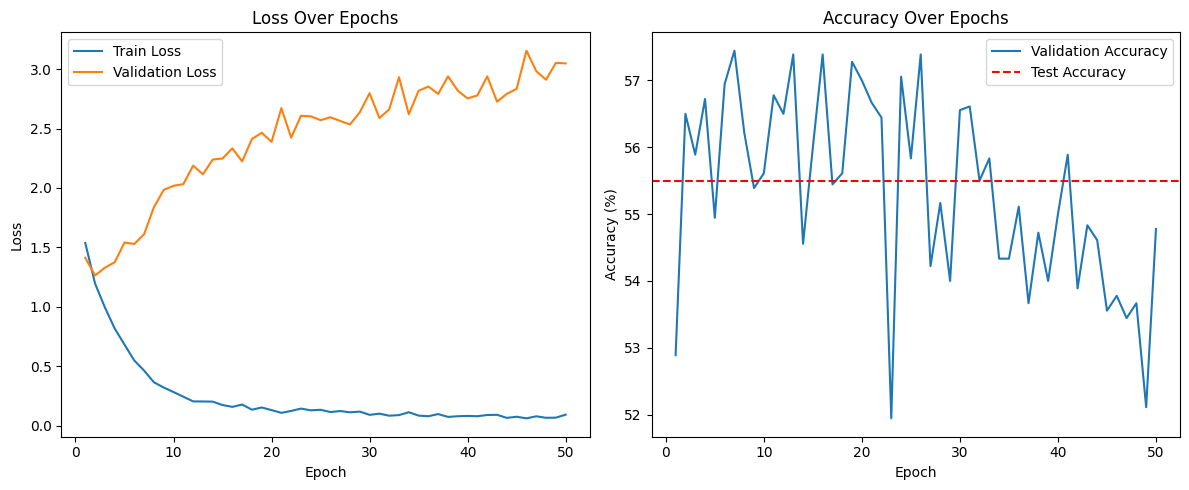

In [ ]:
# رسم نمودار دقت و Loss
def plot_metrics(train_losses, val_losses, val_accuracies, test_accuracy):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # نمودار Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    # نمودار Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.axhline(y=test_accuracy, color='r', linestyle='--', label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, val_losses, val_accuracies, test_accuracy)


In [ ]:
#good
from sklearn.metrics import classification_report

# ارزیابی مدل EfficientNet-B0 با نمایش دقت هر دسته
def evaluate_efficientnet_model_per_category(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to("cuda" if torch.cuda.is_available() else "cpu"), labels.to("cuda" if torch.cuda.is_available() else "cpu")
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # نمایش دقت کلی
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Overall Accuracy: {accuracy * 100:.2f}%")

    # نمایش دقت هر دسته با استفاده از classification_report
    category_names = dataset.categories  # نام دسته‌ها از داده‌ها
    report = classification_report(all_labels, all_preds, target_names=category_names)
    print("\nCategory-wise Accuracy:\n", report)

# فراخوانی تابع ارزیابی
evaluate_efficientnet_model_per_category(efficientnet_model, test_loader)

Overall Accuracy: 91.23%

Category-wise Accuracy:
               precision    recall  f1-score   support

         300       0.98      0.96      0.97       166
         311       0.96      0.97      0.96       127
         248       0.99      0.98      0.99       165
         357       0.97      0.98      0.97       154
         365       0.83      0.82      0.82       158
         321       0.82      0.84      0.83       154
         403       0.93      0.88      0.91       161
         358       0.93      0.95      0.94       155
         242       0.96      0.99      0.98       177
         372       0.71      0.71      0.71       133

    accuracy                           0.91      1550
   macro avg       0.91      0.91      0.91      1550
weighted avg       0.91      0.91      0.91      1550



In [ ]:
from sklearn.metrics import classification_report

# ارزیابی مدل EfficientNet-B0 با نمایش دقت هر دسته
def evaluate_efficientnet_model_per_category(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to("cuda" if torch.cuda.is_available() else "cpu"), labels.to("cuda" if torch.cuda.is_available() else "cpu")
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # نمایش دقت کلی
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Overall Accuracy: {accuracy * 100:.2f}%")

    # نمایش دقت هر دسته با استفاده از classification_report
    category_names = dataset.categories  # نام دسته‌ها از داده‌ها
    report = classification_report(all_labels, all_preds, target_names=category_names)
    print("\nCategory-wise Accuracy:\n", report)

# فراخوانی تابع ارزیابی
evaluate_efficientnet_model_per_category(efficientnet_model, test_loader)

Overall Accuracy: 55.50%

Category-wise Accuracy:
               precision    recall  f1-score   support

         326       0.37      0.36      0.36       180
         365       0.54      0.62      0.57       180
         322       0.36      0.57      0.44       180
         312       0.73      0.52      0.60       180
         311       0.54      0.73      0.62       180
         315       0.56      0.49      0.53       180
         321       0.39      0.17      0.23       180
         313       0.77      0.69      0.73       180
         324       0.74      0.75      0.75       180
         325       0.63      0.66      0.64       180

    accuracy                           0.56      1800
   macro avg       0.56      0.56      0.55      1800
weighted avg       0.56      0.56      0.55      1800



In [ ]:
#good
from torchvision import models
import torch.nn as nn
import torch.optim as optim

# تعریف مدل
efficientnet_model = models.efficientnet_b4(weights='IMAGENET1K_V1')  # استفاده از EfficientNet-B4
num_features = efficientnet_model.classifier[1].in_features
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها (بر اساس داده‌های شما)
efficientnet_model.classifier[1] = nn.Linear(num_features, num_classes)
efficientnet_model = efficientnet_model.to("cuda")

# تعریف Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.0001)  # کاهش Learning Rate برای مدل بزرگ‌تر

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    efficientnet_model, train_loader, val_loader, criterion, optimizer
)

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 104MB/s]


Epoch 1/20, Train Loss: 1.7158, Val Loss: 0.9881, Val Accuracy: 72.70%
Epoch 2/20, Train Loss: 0.7871, Val Loss: 0.6370, Val Accuracy: 78.79%
Epoch 3/20, Train Loss: 0.5948, Val Loss: 0.6195, Val Accuracy: 80.67%
Epoch 4/20, Train Loss: 0.4865, Val Loss: 0.5968, Val Accuracy: 81.37%
Epoch 5/20, Train Loss: 0.4045, Val Loss: 0.5463, Val Accuracy: 82.37%
Epoch 6/20, Train Loss: 0.3475, Val Loss: 0.5315, Val Accuracy: 83.13%
Epoch 7/20, Train Loss: 0.2803, Val Loss: 0.5601, Val Accuracy: 82.89%
Epoch 8/20, Train Loss: 0.2452, Val Loss: 0.5047, Val Accuracy: 83.95%
Epoch 9/20, Train Loss: 0.2043, Val Loss: 0.5070, Val Accuracy: 85.06%
Epoch 10/20, Train Loss: 0.1625, Val Loss: 0.5281, Val Accuracy: 85.12%


KeyboardInterrupt: 

In [ ]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim

# تعریف مدل
efficientnet_model = models.efficientnet_b4(weights='IMAGENET1K_V1')  # استفاده از EfficientNet-B4
num_features = efficientnet_model.classifier[1].in_features
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها (بر اساس داده‌های شما)
efficientnet_model.classifier[1] = nn.Linear(num_features, num_classes)
efficientnet_model = efficientnet_model.to("cuda")

# تعریف Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.0001)  # کاهش Learning Rate برای مدل بزرگ‌تر

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    efficientnet_model, train_loader, val_loader, criterion, optimizer
)

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 173MB/s]


Epoch 1/50, Train Loss: 2.0859, Val Loss: 1.7184, Val Accuracy: 45.56%
Epoch 2/50, Train Loss: 1.5148, Val Loss: 1.4157, Val Accuracy: 51.72%
Epoch 3/50, Train Loss: 1.2844, Val Loss: 1.3110, Val Accuracy: 55.78%
Epoch 4/50, Train Loss: 1.1440, Val Loss: 1.2656, Val Accuracy: 56.72%
Epoch 5/50, Train Loss: 1.0321, Val Loss: 1.2303, Val Accuracy: 57.67%
Epoch 6/50, Train Loss: 0.9357, Val Loss: 1.2211, Val Accuracy: 59.00%
Epoch 7/50, Train Loss: 0.8394, Val Loss: 1.2336, Val Accuracy: 58.28%
Epoch 8/50, Train Loss: 0.7390, Val Loss: 1.2630, Val Accuracy: 58.56%
Epoch 9/50, Train Loss: 0.6646, Val Loss: 1.2973, Val Accuracy: 58.67%
Epoch 10/50, Train Loss: 0.5651, Val Loss: 1.3220, Val Accuracy: 59.44%
Epoch 11/50, Train Loss: 0.5022, Val Loss: 1.3967, Val Accuracy: 59.78%
Epoch 12/50, Train Loss: 0.4222, Val Loss: 1.4936, Val Accuracy: 60.50%
Epoch 13/50, Train Loss: 0.3725, Val Loss: 1.5515, Val Accuracy: 60.11%
Epoch 14/50, Train Loss: 0.3246, Val Loss: 1.6141, Val Accuracy: 60.50%
E

In [ ]:
#good
# ارزیابی روی داده‌های Test
def evaluate_model_on_test(model, test_loader):
    model.eval()
    test_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
    return test_loss / len(test_loader), test_accuracy * 100

test_loss, test_accuracy = evaluate_model_on_test(efficientnet_model, test_loader)

Test Loss: 0.4649, Test Accuracy: 86.88%


In [ ]:
# ارزیابی روی داده‌های Test
def evaluate_model_on_test(model, test_loader):
    model.eval()
    test_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
    return test_loss / len(test_loader), test_accuracy * 100

test_loss, test_accuracy = evaluate_model_on_test(efficientnet_model, test_loader)


Test Loss: 2.4605, Test Accuracy: 62.00%


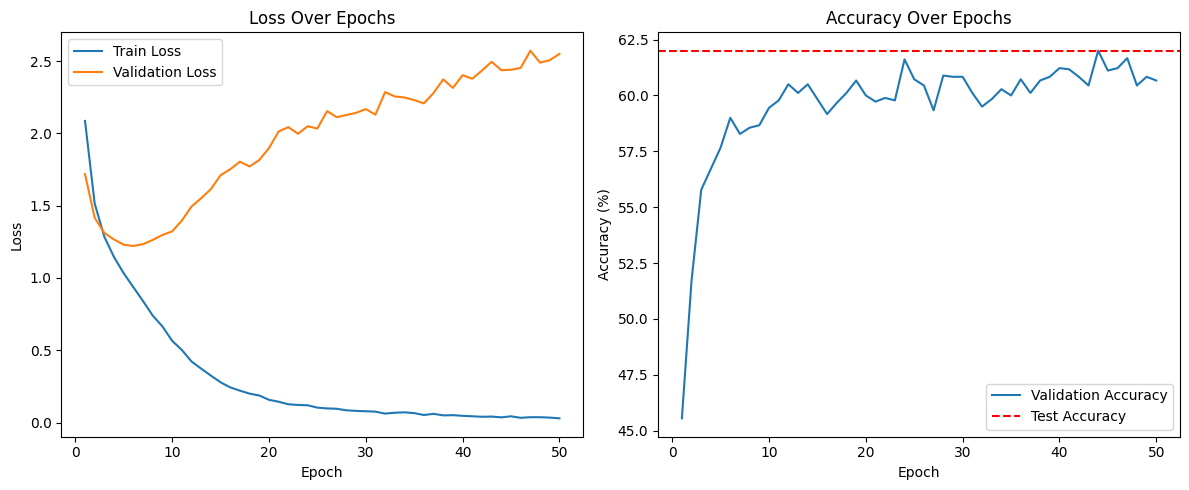

In [ ]:
# رسم نمودار دقت و Loss
def plot_metrics(train_losses, val_losses, val_accuracies, test_accuracy):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # نمودار Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    # نمودار Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.axhline(y=test_accuracy, color='r', linestyle='--', label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, val_losses, val_accuracies, test_accuracy)


In [ ]:
from sklearn.metrics import classification_report

# ارزیابی مدل EfficientNet-B0 با نمایش دقت هر دسته
def evaluate_efficientnet_model_per_category(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to("cuda" if torch.cuda.is_available() else "cpu"), labels.to("cuda" if torch.cuda.is_available() else "cpu")
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # نمایش دقت کلی
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Overall Accuracy: {accuracy * 100:.2f}%")

    # نمایش دقت هر دسته با استفاده از classification_report
    category_names = dataset.categories  # نام دسته‌ها از داده‌ها
    report = classification_report(all_labels, all_preds, target_names=category_names)
    print("\nCategory-wise Accuracy:\n", report)

# فراخوانی تابع ارزیابی
evaluate_efficientnet_model_per_category(efficientnet_model, test_loader)

Overall Accuracy: 62.00%

Category-wise Accuracy:
               precision    recall  f1-score   support

         326       0.50      0.38      0.43       180
         365       0.64      0.69      0.66       180
         322       0.50      0.51      0.50       180
         312       0.71      0.73      0.72       180
         311       0.69      0.64      0.66       180
         315       0.50      0.61      0.55       180
         321       0.43      0.34      0.38       180
         313       0.70      0.73      0.72       180
         324       0.83      0.78      0.81       180
         325       0.66      0.79      0.72       180

    accuracy                           0.62      1800
   macro avg       0.62      0.62      0.62      1800
weighted avg       0.62      0.62      0.62      1800



In [ ]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim

# تعریف مدل
densenet_model = models.densenet201(weights='IMAGENET1K_V1')  # استفاده از DenseNet-201
num_features = densenet_model.classifier.in_features
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها (بر اساس داده‌های شما)
densenet_model.classifier = nn.Linear(num_features, num_classes)
densenet_model = densenet_model.to("cuda")

# فریز کردن لایه‌های اولیه
for param in densenet_model.features.parameters():
  param.requires_grad = False

# تعریف Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(densenet_model.parameters(), lr=0.0001)

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    densenet_model, train_loader, val_loader, criterion, optimizer
)

Epoch 1/50, Train Loss: 2.0728, Val Loss: 1.8178, Val Accuracy: 41.39%
Epoch 2/50, Train Loss: 1.7096, Val Loss: 1.6068, Val Accuracy: 47.44%


KeyboardInterrupt: 

In [ ]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim

# مدل EfficientNet-B4
efficientnet_model = models.efficientnet_b4(weights='IMAGENET1K_V1')
num_features = efficientnet_model.classifier[1].in_features
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها
efficientnet_model.classifier[1] = nn.Linear(num_features, num_classes)
efficientnet_model = efficientnet_model.to("cuda")

# Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(efficientnet_model.parameters(), lr=0.00005)  # AdamW برای همگرایی بهتر

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    efficientnet_model, train_loader, val_loader, criterion, optimizer
)


Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:01<00:00, 46.3MB/s]


Epoch 1/50, Train Loss: 2.2198, Val Loss: 2.0860, Val Accuracy: 38.11%
Epoch 2/50, Train Loss: 1.8990, Val Loss: 1.6990, Val Accuracy: 46.00%
Epoch 3/50, Train Loss: 1.5618, Val Loss: 1.4707, Val Accuracy: 50.56%
Epoch 4/50, Train Loss: 1.3819, Val Loss: 1.3694, Val Accuracy: 51.94%
Epoch 5/50, Train Loss: 1.2924, Val Loss: 1.3622, Val Accuracy: 53.83%
Epoch 6/50, Train Loss: 1.2061, Val Loss: 1.2706, Val Accuracy: 55.50%
Epoch 7/50, Train Loss: 1.1434, Val Loss: 1.2408, Val Accuracy: 56.67%
Epoch 8/50, Train Loss: 1.0880, Val Loss: 1.2402, Val Accuracy: 56.39%
Epoch 9/50, Train Loss: 1.0228, Val Loss: 1.2192, Val Accuracy: 57.72%
Epoch 10/50, Train Loss: 0.9679, Val Loss: 1.2128, Val Accuracy: 57.50%


KeyboardInterrupt: 

In [ ]:
from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from PIL import Image
import os
import numpy as np

# تنظیمات مدل
IMAGE_SIZE = 224  # تغییر به 224x224 برای ViT
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001

# 1. آماده‌سازی داده‌ها
class CustomDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.categories = os.listdir(image_dir)

        # خواندن تصاویر و برچسب‌ها
        for label, category in enumerate(self.categories):
            category_path = os.path.join(image_dir, category)
            for image_name in os.listdir(category_path):
                if image_name.endswith(".jpg") or image_name.endswith(".png"):
                    self.images.append(os.path.join(category_path, image_name))
                    self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label

# استفاده از ViTFeatureExtractor برای تغییرات مناسب
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])

# بارگذاری داده‌ها
image_dir = "/content/images_files/good_images"
dataset = CustomDataset(image_dir, transform)

# تقسیم داده‌ها به Train، Validation و Test
train_data, temp_data = train_test_split(dataset, test_size=0.3, stratify=dataset.labels)
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=[d[1] for d in temp_data])

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# 2. تعریف مدل ViT
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(set(dataset.labels))  # تعداد کلاس‌ها
)
model = model.to("cuda")

# 3. تعریف Criterion و Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 4. تابع آموزش
def train_model_with_validation(model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        # آموزش روی داده‌های Train
        for images, labels in train_loader:
            images, labels = images.to("cuda"), labels.to("cuda")
            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # ارزیابی روی داده‌های Validation
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to("cuda"), labels.to("cuda")
                outputs = model(images).logits
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy * 100)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%")

    return train_losses, val_losses, val_accuracies

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    model, train_loader, val_loader, criterion, optimizer
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20, Train Loss: 0.7031, Val Loss: 0.3420, Val Accuracy: 91.97%
Epoch 2/20, Train Loss: 0.1878, Val Loss: 0.3587, Val Accuracy: 89.92%
Epoch 3/20, Train Loss: 0.0938, Val Loss: 0.3315, Val Accuracy: 91.15%
Epoch 4/20, Train Loss: 0.0533, Val Loss: 0.3944, Val Accuracy: 89.40%
Epoch 5/20, Train Loss: 0.0529, Val Loss: 0.3852, Val Accuracy: 90.39%
Epoch 6/20, Train Loss: 0.0437, Val Loss: 0.4200, Val Accuracy: 90.57%
Epoch 7/20, Train Loss: 0.0480, Val Loss: 0.5123, Val Accuracy: 87.93%
Epoch 8/20, Train Loss: 0.0262, Val Loss: 0.4625, Val Accuracy: 89.22%


KeyboardInterrupt: 

In [ ]:
# مسیر ذخیره مدل در گوگل درایو
save_path = '/content/drive/MyDrive/vit_model.pth'

# ذخیره مدل آموزش‌دیده
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")


Model saved to /content/drive/MyDrive/vit_model.pth


In [ ]:
from torchvision.models.vision_transformer import vit_b_16

# مدل Vision Transformer
vit_model = vit_b_16(weights='IMAGENET1K_V1')
num_features = vit_model.heads.head.in_features
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها
vit_model.heads.head = nn.Linear(num_features, num_classes)
vit_model = vit_model.to("cuda")

# Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(vit_model.parameters(), lr=0.00005)

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    vit_model, train_loader, val_loader, criterion, optimizer
)


TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

In [ ]:
#good
# مدل DenseNet-201
densenet_model = models.densenet201(weights='IMAGENET1K_V1')
num_features = densenet_model.classifier.in_features
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها
densenet_model.classifier = nn.Linear(num_features, num_classes)
densenet_model = densenet_model.to("cuda")

# Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(densenet_model.parameters(), lr=0.00001)

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    densenet_model, train_loader, val_loader, criterion, optimizer
)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 141MB/s]


Epoch 1/20, Train Loss: 0.6853, Val Loss: 0.4230, Val Accuracy: 85.59%
Epoch 2/20, Train Loss: 0.2191, Val Loss: 0.4142, Val Accuracy: 87.40%
Epoch 3/20, Train Loss: 0.0965, Val Loss: 0.4844, Val Accuracy: 86.06%
Epoch 4/20, Train Loss: 0.0541, Val Loss: 0.5265, Val Accuracy: 86.99%


KeyboardInterrupt: 

In [ ]:
#good
# ارزیابی روی داده‌های Test
def evaluate_model_on_test(model, test_loader):
    model.eval()
    test_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
    return test_loss / len(test_loader), test_accuracy * 100

test_loss, test_accuracy = evaluate_model_on_test(densenet_model, test_loader)

Test Loss: 0.4365, Test Accuracy: 87.58%


In [ ]:
# مدل DenseNet-201
densenet_model = models.densenet201(weights='IMAGENET1K_V1')
num_features = densenet_model.classifier.in_features
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها
densenet_model.classifier = nn.Linear(num_features, num_classes)
densenet_model = densenet_model.to("cuda")

# Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(densenet_model.parameters(), lr=0.0001)

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    densenet_model, train_loader, val_loader, criterion, optimizer
)

Epoch 1/20, Train Loss: 1.3423, Val Loss: 1.0968, Val Accuracy: 63.44%
Epoch 2/20, Train Loss: 0.6885, Val Loss: 1.1084, Val Accuracy: 64.06%
Epoch 3/20, Train Loss: 0.3106, Val Loss: 1.2198, Val Accuracy: 64.00%
Epoch 4/20, Train Loss: 0.1417, Val Loss: 1.3004, Val Accuracy: 64.00%
Epoch 5/20, Train Loss: 0.0849, Val Loss: 1.4742, Val Accuracy: 64.06%
Epoch 6/20, Train Loss: 0.0910, Val Loss: 1.5222, Val Accuracy: 63.22%
Epoch 7/20, Train Loss: 0.1093, Val Loss: 1.5999, Val Accuracy: 62.22%
Epoch 8/20, Train Loss: 0.0788, Val Loss: 1.6566, Val Accuracy: 62.94%


KeyboardInterrupt: 

In [ ]:
# مدل DenseNet-201
densenet_model = models.densenet201(weights='IMAGENET1K_V1')
num_features = densenet_model.classifier.in_features
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها
densenet_model.classifier = nn.Linear(num_features, num_classes)

# فریز کردن همه لایه‌ها جز لایه‌ی آخر
for param in densenet_model.parameters():
    param.requires_grad = False
for param in densenet_model.classifier.parameters():
    param.requires_grad = True

densenet_model = densenet_model.to("cuda")

# Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(densenet_model.classifier.parameters(), lr=0.0001)

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    densenet_model, train_loader, val_loader, criterion, optimizer
)


Epoch 1/20, Train Loss: 2.0861, Val Loss: 1.8808, Val Accuracy: 39.28%
Epoch 2/20, Train Loss: 1.7213, Val Loss: 1.6593, Val Accuracy: 46.39%
Epoch 3/20, Train Loss: 1.5459, Val Loss: 1.5445, Val Accuracy: 51.00%
Epoch 4/20, Train Loss: 1.4484, Val Loss: 1.4769, Val Accuracy: 53.06%
Epoch 5/20, Train Loss: 1.3931, Val Loss: 1.4408, Val Accuracy: 53.61%


KeyboardInterrupt: 

In [ ]:
# مدل DenseNet-201
densenet_model = models.densenet201(weights='IMAGENET1K_V1')
num_features = densenet_model.classifier.in_features
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها
densenet_model.classifier = nn.Linear(num_features, num_classes)

# فریز کردن تمام لایه‌ها
for param in densenet_model.parameters():
    param.requires_grad = False

# باز کردن آموزش فقط 5 لایه‌ی آخر
for name, param in list(densenet_model.named_parameters())[-10:]:
    param.requires_grad = True
    print(f"Training layer: {name}")  # برای اطمینان از لایه‌های باز

densenet_model = densenet_model.to("cuda")

# Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, densenet_model.parameters()), lr=0.0001)

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    densenet_model, train_loader, val_loader, criterion, optimizer
)


Training layer: features.denseblock4.denselayer32.norm1.weight
Training layer: features.denseblock4.denselayer32.norm1.bias
Training layer: features.denseblock4.denselayer32.conv1.weight
Training layer: features.denseblock4.denselayer32.norm2.weight
Training layer: features.denseblock4.denselayer32.norm2.bias
Training layer: features.denseblock4.denselayer32.conv2.weight
Training layer: features.norm5.weight
Training layer: features.norm5.bias
Training layer: classifier.weight
Training layer: classifier.bias
Epoch 1/20, Train Loss: 1.9786, Val Loss: 1.6830, Val Accuracy: 47.06%
Epoch 2/20, Train Loss: 1.5254, Val Loss: 1.4267, Val Accuracy: 54.17%
Epoch 3/20, Train Loss: 1.3232, Val Loss: 1.3134, Val Accuracy: 57.33%
Epoch 4/20, Train Loss: 1.1804, Val Loss: 1.2451, Val Accuracy: 58.83%
Epoch 5/20, Train Loss: 1.0625, Val Loss: 1.2052, Val Accuracy: 59.39%


KeyboardInterrupt: 

In [ ]:
# مدل ResNet-101
resnet_model = models.resnet101(weights='IMAGENET1K_V1')
num_features = resnet_model.fc.in_features
num_classes = len(set(dataset.labels))  # تعداد کلاس‌ها
resnet_model.fc = nn.Linear(num_features, num_classes)

# فریز کردن تمام لایه‌ها
for param in resnet_model.parameters():
    param.requires_grad = False

# باز کردن آموزش فقط 5 لایه‌ی آخر
for name, param in list(resnet_model.named_parameters())[-10:]:
    param.requires_grad = True
    print(f"Training layer: {name}")  # برای اطمینان از لایه‌های باز

resnet_model = resnet_model.to("cuda")

# Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, resnet_model.parameters()), lr=0.001, momentum=0.9, weight_decay=1e-4)

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    resnet_model, train_loader, val_loader, criterion, optimizer
)


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 137MB/s]


Training layer: layer4.2.bn1.weight
Training layer: layer4.2.bn1.bias
Training layer: layer4.2.conv2.weight
Training layer: layer4.2.bn2.weight
Training layer: layer4.2.bn2.bias
Training layer: layer4.2.conv3.weight
Training layer: layer4.2.bn3.weight
Training layer: layer4.2.bn3.bias
Training layer: fc.weight
Training layer: fc.bias
Epoch 1/20, Train Loss: 1.5784, Val Loss: 1.3977, Val Accuracy: 53.56%
Epoch 2/20, Train Loss: 1.2908, Val Loss: 1.3165, Val Accuracy: 55.39%
Epoch 3/20, Train Loss: 1.1963, Val Loss: 1.3190, Val Accuracy: 55.94%
Epoch 4/20, Train Loss: 1.1185, Val Loss: 1.3045, Val Accuracy: 55.44%
Epoch 5/20, Train Loss: 1.0417, Val Loss: 1.2920, Val Accuracy: 57.33%


KeyboardInterrupt: 

In [ ]:
# ارزیابی روی داده‌های Test
def evaluate_model_on_test(model, test_loader):
    model.eval()
    test_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
    return test_loss / len(test_loader), test_accuracy * 100

test_loss, test_accuracy = evaluate_model_on_test(efficientnet_model, test_loader)


Test Loss: 1.2659, Test Accuracy: 58.33%


In [ ]:
# رسم نمودار دقت و Loss
def plot_metrics(train_losses, val_losses, val_accuracies, test_accuracy):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # نمودار Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    # نمودار Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.axhline(y=test_accuracy, color='r', linestyle='--', label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, val_losses, val_accuracies, test_accuracy)


NameError: name 'train_losses' is not defined

In [ ]:
from sklearn.metrics import classification_report

# ارزیابی مدل EfficientNet-B0 با نمایش دقت هر دسته
def evaluate_efficientnet_model_per_category(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to("cuda" if torch.cuda.is_available() else "cpu"), labels.to("cuda" if torch.cuda.is_available() else "cpu")
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # نمایش دقت کلی
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Overall Accuracy: {accuracy * 100:.2f}%")

    # نمایش دقت هر دسته با استفاده از classification_report
    category_names = dataset.categories  # نام دسته‌ها از داده‌ها
    report = classification_report(all_labels, all_preds, target_names=category_names)
    print("\nCategory-wise Accuracy:\n", report)

# فراخوانی تابع ارزیابی
evaluate_efficientnet_model_per_category(efficientndensenet_modelet_model, test_loader)

NameError: name 'efficientnet_model' is not defined

In [ ]:
from timm import create_model
import torch.nn as nn
import torch.optim as optim

# تعریف مدل EfficientNet-V2
efficientnet_v2 = create_model("tf_efficientnetv2_m", pretrained=True, num_classes=num_classes)

# Freeze کردن لایه‌های اولیه
for param in efficientnet_v2.parameters():
    param.requires_grad = False

# بازکردن لایه‌های classifier برای آموزش
for param in efficientnet_v2.classifier.parameters():
    param.requires_grad = True

# انتقال مدل به GPU
efficientnet_v2 = efficientnet_v2.to("cuda")

# تعریف Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_v2.parameters(), lr=0.0001)

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    efficientnet_v2, train_loader, val_loader, criterion, optimizer
)


Epoch 1/50, Train Loss: 9.8844, Val Loss: 8.8529, Val Accuracy: 12.39%
Epoch 2/50, Train Loss: 8.7091, Val Loss: 7.9209, Val Accuracy: 13.78%
Epoch 3/50, Train Loss: 7.9967, Val Loss: 7.4751, Val Accuracy: 15.67%
Epoch 4/50, Train Loss: 7.4834, Val Loss: 7.2452, Val Accuracy: 16.83%
Epoch 5/50, Train Loss: 7.0167, Val Loss: 6.9099, Val Accuracy: 19.39%
Epoch 6/50, Train Loss: 6.5866, Val Loss: 6.5609, Val Accuracy: 20.39%
Epoch 7/50, Train Loss: 6.2558, Val Loss: 6.2674, Val Accuracy: 22.33%
Epoch 8/50, Train Loss: 5.9871, Val Loss: 6.0011, Val Accuracy: 23.94%
Epoch 9/50, Train Loss: 5.6796, Val Loss: 5.8262, Val Accuracy: 25.67%
Epoch 10/50, Train Loss: 5.5138, Val Loss: 5.5999, Val Accuracy: 26.44%
Epoch 11/50, Train Loss: 5.3256, Val Loss: 5.4837, Val Accuracy: 27.11%
Epoch 12/50, Train Loss: 5.0504, Val Loss: 5.3411, Val Accuracy: 28.06%
Epoch 13/50, Train Loss: 4.9867, Val Loss: 5.1893, Val Accuracy: 29.17%
Epoch 14/50, Train Loss: 4.8048, Val Loss: 4.9918, Val Accuracy: 30.22%
E

In [ ]:
# ارزیابی روی داده‌های Test
def evaluate_model_on_test(model, test_loader):
    model.eval()
    test_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
    return test_loss / len(test_loader), test_accuracy * 100

test_loss, test_accuracy = evaluate_model_on_test(efficientnet_model, test_loader)


Test Loss: 2.4605, Test Accuracy: 62.00%


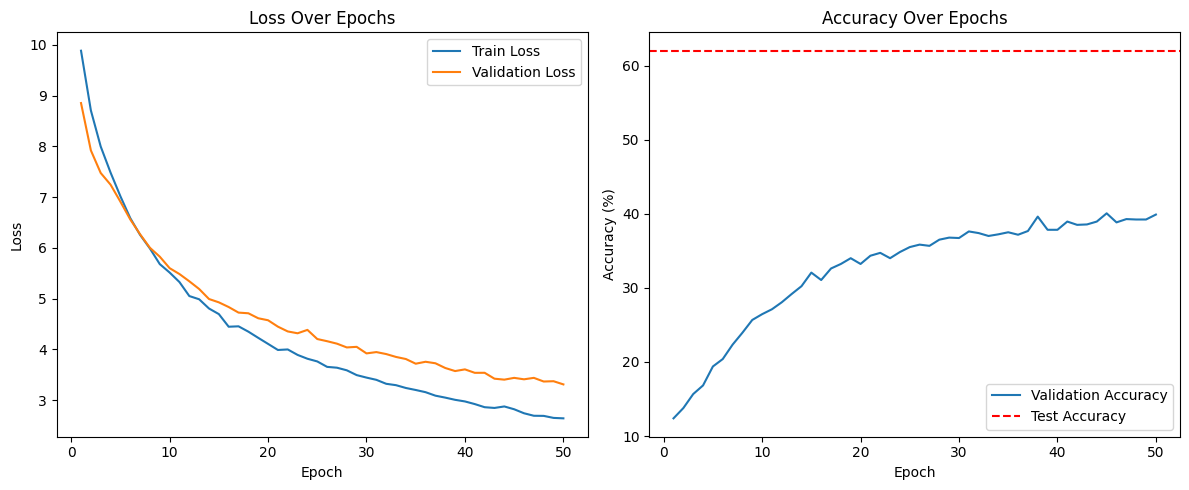

In [ ]:
# رسم نمودار دقت و Loss
def plot_metrics(train_losses, val_losses, val_accuracies, test_accuracy):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # نمودار Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    # نمودار Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.axhline(y=test_accuracy, color='r', linestyle='--', label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, val_losses, val_accuracies, test_accuracy)


In [ ]:
from sklearn.metrics import classification_report

# ارزیابی مدل EfficientNet-B0 با نمایش دقت هر دسته
def evaluate_efficientnet_model_per_category(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to("cuda" if torch.cuda.is_available() else "cpu"), labels.to("cuda" if torch.cuda.is_available() else "cpu")
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # نمایش دقت کلی
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Overall Accuracy: {accuracy * 100:.2f}%")

    # نمایش دقت هر دسته با استفاده از classification_report
    category_names = dataset.categories  # نام دسته‌ها از داده‌ها
    report = classification_report(all_labels, all_preds, target_names=category_names)
    print("\nCategory-wise Accuracy:\n", report)

# فراخوانی تابع ارزیابی
evaluate_efficientnet_model_per_category(efficientnet_model, test_loader)

NameError: name 'efficientnet_model' is not defined

#2_leyer

In [ ]:

# تعریف تنظیمات و پارامترها
IMAGE_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001

In [ ]:
# تابع آموزش مدل
def train_model_with_validation(model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        # آموزش روی داده‌های Train
        for images, labels in train_loader:
            images, labels = images.to("cuda"), labels.to("cuda")
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # ارزیابی روی داده‌های Validation
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to("cuda"), labels.to("cuda")
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy * 100)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%")

    return train_losses, val_losses, val_accuracies


In [ ]:
# تعریف مدل
efficientnet_model = models.efficientnet_b0(weights='IMAGENET1K_V1')
for param in efficientnet_model.parameters():
    param.requires_grad = False  # فریز کردن لایه‌های ابتدایی

# باز کردن دو لایه آخر برای یادگیری
for param in list(efficientnet_model.classifier[-2:].parameters()):
    param.requires_grad = True

# تنظیم لایه‌های نهایی
num_features = efficientnet_model.classifier[1].in_features
efficientnet_model.classifier[1] = nn.Linear(num_features, len(dataset.categories))

# آموزش مدل EfficientNet-B0
efficientnet_model = efficientnet_model.to("cuda" if torch.cuda.is_available() else "cpu")

# تعریف Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.001)

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    efficientnet_model, train_loader, val_loader, criterion, optimizer
)




Epoch 1/20, Train Loss: 1.7573, Val Loss: 1.5431, Val Accuracy: 49.44%
Epoch 2/20, Train Loss: 1.4970, Val Loss: 1.4899, Val Accuracy: 49.17%
Epoch 3/20, Train Loss: 1.4298, Val Loss: 1.4480, Val Accuracy: 51.33%
Epoch 4/20, Train Loss: 1.4125, Val Loss: 1.4503, Val Accuracy: 51.39%
Epoch 5/20, Train Loss: 1.3697, Val Loss: 1.4480, Val Accuracy: 52.28%
Epoch 6/20, Train Loss: 1.3534, Val Loss: 1.4530, Val Accuracy: 51.17%
Epoch 7/20, Train Loss: 1.3466, Val Loss: 1.4521, Val Accuracy: 51.56%
Epoch 8/20, Train Loss: 1.3429, Val Loss: 1.4499, Val Accuracy: 51.78%
Epoch 9/20, Train Loss: 1.3410, Val Loss: 1.4520, Val Accuracy: 52.00%
Epoch 10/20, Train Loss: 1.3340, Val Loss: 1.4418, Val Accuracy: 51.83%
Epoch 11/20, Train Loss: 1.3393, Val Loss: 1.4644, Val Accuracy: 51.67%
Epoch 12/20, Train Loss: 1.3330, Val Loss: 1.4567, Val Accuracy: 51.17%
Epoch 13/20, Train Loss: 1.3211, Val Loss: 1.4568, Val Accuracy: 51.22%
Epoch 14/20, Train Loss: 1.3349, Val Loss: 1.4595, Val Accuracy: 51.89%
E

In [ ]:
# ارزیابی روی داده‌های Test
def evaluate_model_on_test(model, test_loader):
    model.eval()
    test_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
    return test_loss / len(test_loader), test_accuracy * 100

test_loss, test_accuracy = evaluate_model_on_test(efficientnet_model, test_loader)


Test Loss: 1.4490, Test Accuracy: 50.50%


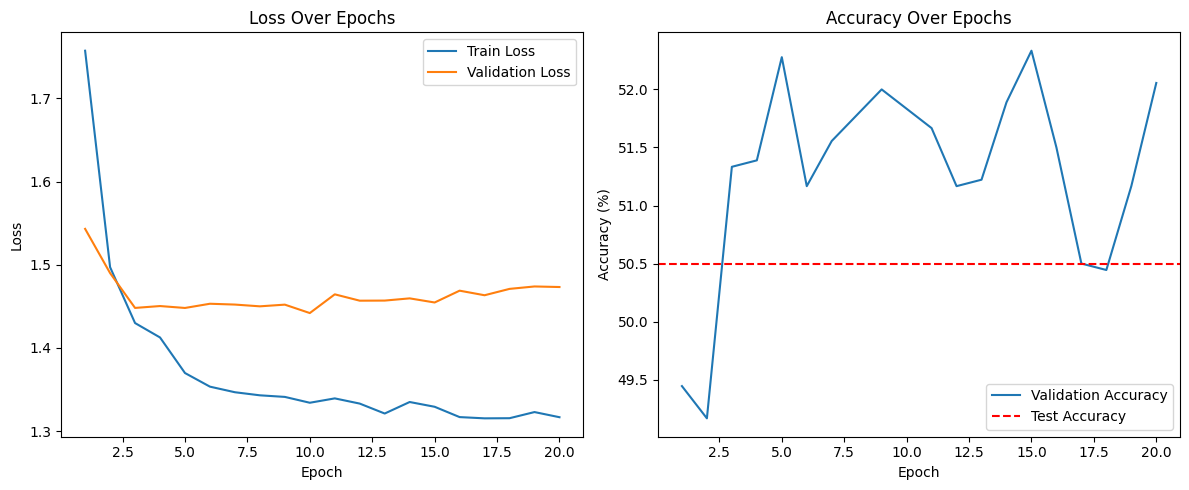

In [ ]:
# رسم نمودار دقت و Loss
def plot_metrics(train_losses, val_losses, val_accuracies, test_accuracy):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # نمودار Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    # نمودار Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.axhline(y=test_accuracy, color='r', linestyle='--', label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, val_losses, val_accuracies, test_accuracy)


In [ ]:
from sklearn.metrics import classification_report

# ارزیابی مدل EfficientNet-B0 با نمایش دقت هر دسته
def evaluate_efficientnet_model_per_category(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to("cuda" if torch.cuda.is_available() else "cpu"), labels.to("cuda" if torch.cuda.is_available() else "cpu")
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # نمایش دقت کلی
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Overall Accuracy: {accuracy * 100:.2f}%")

    # نمایش دقت هر دسته با استفاده از classification_report
    category_names = dataset.categories  # نام دسته‌ها از داده‌ها
    report = classification_report(all_labels, all_preds, target_names=category_names)
    print("\nCategory-wise Accuracy:\n", report)

# فراخوانی تابع ارزیابی
evaluate_efficientnet_model_per_category(efficientnet_model, test_loader)

Overall Accuracy: 50.50%

Category-wise Accuracy:
               precision    recall  f1-score   support

         326       0.36      0.42      0.39       180
         365       0.51      0.57      0.54       180
         322       0.41      0.37      0.39       180
         312       0.56      0.60      0.58       180
         311       0.57      0.62      0.59       180
         315       0.44      0.48      0.46       180
         321       0.37      0.26      0.30       180
         313       0.60      0.58      0.59       180
         324       0.62      0.66      0.64       180
         325       0.61      0.49      0.55       180

    accuracy                           0.51      1800
   macro avg       0.50      0.51      0.50      1800
weighted avg       0.50      0.51      0.50      1800



#5_leyer

In [ ]:

# تعریف تنظیمات و پارامترها
IMAGE_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001

In [ ]:
# تابع آموزش مدل
def train_model_with_validation(model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        # آموزش روی داده‌های Train
        for images, labels in train_loader:
            images, labels = images.to("cuda"), labels.to("cuda")
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # ارزیابی روی داده‌های Validation
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to("cuda"), labels.to("cuda")
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy * 100)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%")

    return train_losses, val_losses, val_accuracies


In [ ]:
# تعریف مدل
efficientnet_model = models.efficientnet_b0(weights='IMAGENET1K_V1')
for param in efficientnet_model.parameters():
    param.requires_grad = False  # فریز کردن لایه‌های ابتدایی

# باز کردن دو لایه آخر برای یادگیری
for param in list(efficientnet_model.classifier[-5:].parameters()):
    param.requires_grad = True

# تنظیم لایه‌های نهایی
num_features = efficientnet_model.classifier[1].in_features
efficientnet_model.classifier[1] = nn.Linear(num_features, len(dataset.categories))

# آموزش مدل EfficientNet-B0
efficientnet_model = efficientnet_model.to("cuda" if torch.cuda.is_available() else "cpu")

# تعریف Criterion و Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.001)

# آموزش مدل
train_losses, val_losses, val_accuracies = train_model_with_validation(
    efficientnet_model, train_loader, val_loader, criterion, optimizer
)




Epoch 1/20, Train Loss: 1.7549, Val Loss: 1.5298, Val Accuracy: 49.83%
Epoch 2/20, Train Loss: 1.4877, Val Loss: 1.4577, Val Accuracy: 50.67%
Epoch 3/20, Train Loss: 1.4418, Val Loss: 1.4556, Val Accuracy: 51.22%
Epoch 4/20, Train Loss: 1.4076, Val Loss: 1.4540, Val Accuracy: 50.56%
Epoch 5/20, Train Loss: 1.3765, Val Loss: 1.4515, Val Accuracy: 50.61%
Epoch 6/20, Train Loss: 1.3669, Val Loss: 1.4482, Val Accuracy: 52.22%
Epoch 7/20, Train Loss: 1.3546, Val Loss: 1.4585, Val Accuracy: 51.11%
Epoch 8/20, Train Loss: 1.3470, Val Loss: 1.4599, Val Accuracy: 51.89%
Epoch 9/20, Train Loss: 1.3286, Val Loss: 1.4631, Val Accuracy: 51.72%
Epoch 10/20, Train Loss: 1.3327, Val Loss: 1.4649, Val Accuracy: 51.44%
Epoch 11/20, Train Loss: 1.3208, Val Loss: 1.4761, Val Accuracy: 51.94%
Epoch 12/20, Train Loss: 1.3303, Val Loss: 1.4756, Val Accuracy: 51.22%
Epoch 13/20, Train Loss: 1.3211, Val Loss: 1.4732, Val Accuracy: 51.67%
Epoch 14/20, Train Loss: 1.3367, Val Loss: 1.4830, Val Accuracy: 50.67%
E

In [ ]:
# ارزیابی روی داده‌های Test
def evaluate_model_on_test(model, test_loader):
    model.eval()
    test_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
    return test_loss / len(test_loader), test_accuracy * 100

test_loss, test_accuracy = evaluate_model_on_test(efficientnet_model, test_loader)


Test Loss: 1.4565, Test Accuracy: 50.22%


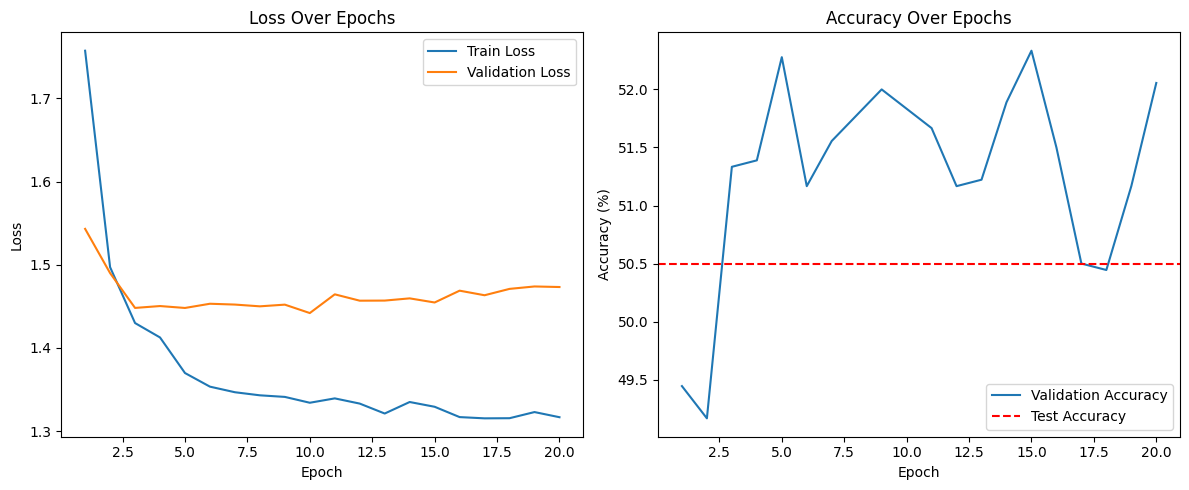

In [ ]:
# رسم نمودار دقت و Loss
def plot_metrics(train_losses, val_losses, val_accuracies, test_accuracy):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # نمودار Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    # نمودار Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.axhline(y=test_accuracy, color='r', linestyle='--', label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, val_losses, val_accuracies, test_accuracy)


In [ ]:
from sklearn.metrics import classification_report

# ارزیابی مدل EfficientNet-B0 با نمایش دقت هر دسته
def evaluate_efficientnet_model_per_category(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to("cuda" if torch.cuda.is_available() else "cpu"), labels.to("cuda" if torch.cuda.is_available() else "cpu")
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # نمایش دقت کلی
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Overall Accuracy: {accuracy * 100:.2f}%")

    # نمایش دقت هر دسته با استفاده از classification_report
    category_names = dataset.categories  # نام دسته‌ها از داده‌ها
    report = classification_report(all_labels, all_preds, target_names=category_names)
    print("\nCategory-wise Accuracy:\n", report)

# فراخوانی تابع ارزیابی
evaluate_efficientnet_model_per_category(efficientnet_model, test_loader)

Overall Accuracy: 50.22%

Category-wise Accuracy:
               precision    recall  f1-score   support

         326       0.36      0.41      0.38       180
         365       0.57      0.54      0.56       180
         322       0.36      0.37      0.37       180
         312       0.59      0.58      0.58       180
         311       0.53      0.63      0.58       180
         315       0.46      0.51      0.48       180
         321       0.36      0.25      0.29       180
         313       0.59      0.57      0.58       180
         324       0.68      0.61      0.64       180
         325       0.53      0.54      0.54       180

    accuracy                           0.50      1800
   macro avg       0.50      0.50      0.50      1800
weighted avg       0.50      0.50      0.50      1800

